The main function is mnistTrainPlot, which can be seen executed twice at the bottom. it plots the losses and some sample images, the images have increasing c2/c3 from -2 to 2 (trained on -1 to 1) as the row increases, and a c1 code increasing as the column increases. Ideally you would see each column representing a digit and in that column the digit should take many forms and generally rotate or appear to have a thicker font, just like the effect of c2 and c3 in the InfoGAN article. As you can see, this is NOT the case. First the experiment is ran with all the custom losses to maximize mutual information and make use of steep curves with log loss for the disciminator and the generator, then the same settings are used, this time with simpler losses like categorical crossentropy, mse and binary crossentropy. Neither of those settings produce good results.

It seemed to be the case that the discriminator loss curve has nothing to do with the quality of the image, generally the discriminator is very strong and its loss falls to 0, the generator loss fluctuates but never drops to 0. It is suggested to use learning rates of 1e-3 for G and 2e-4 for D in the article but this was not really useful for us. above 1e-4 there is a risk of gradient explosion and once it is broken, it's too late and the training process is ruined.

In [1]:
import numpy as np
import keras
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import datetime
import keras.backend as K
import time
from keras.models import load_model
import os

In [2]:
print('python: 3.8.5')
for package in [np, tf, tfds, keras, matplotlib, keras]:
    print(f'-{package.__name__}: {package.__version__}')

python: 3.8.5
-numpy: 1.19.5
-tensorflow: 2.4.1
-tensorflow_datasets: 4.2.0
-keras: 2.4.3
-matplotlib: 3.3.3
-keras: 2.4.3


In [3]:
# https://stackoverflow.com/a/66174336/10945691
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

In [5]:
def strtime():
    return time.strftime("%Y-%m-%d %H-%M-%S")
strtime()

'2021-04-18 21-30-39'

In [6]:
def discriminator_loss_real(y, y_pred):
    real_loss = tf.math.log(y_pred + 1e-6)
    return - tf.reduce_mean(real_loss, axis = -1)

In [7]:
def discriminator_loss_fake(y, y_pred):
    fake_loss = tf.math.log(1. - y_pred + 1e-6)
    return - tf.reduce_mean(fake_loss, axis = -1)

In [8]:
def generator_loss(y, y_pred):
    return - tf.reduce_mean(tf.math.log(y_pred + 1e-6))

In [9]:
# https://github.com/EmilienDupont/infogan/blob/88bc0ef33ff76d3d96296ed9352f681fe59f4ea8/util.py#L12

def discrete_mutual_information_loss(c_disc, aux_dist):
    logliprior = K.log(1/aux_dist.get_shape().as_list()[-1] + 1e-6)
    cross_ent = - K.mean(K.sum(K.log(aux_dist + 1e-6) * c_disc, axis=1))
    ent = - K.mean(K.sum(logliprior * c_disc, axis=1))
    return ent - cross_ent

In [10]:
def continuous_mutual_information_loss(c_cont, aux_dist):
    raise 1

In [11]:
def get_discriminators(input_shape, kernel_initializer, qcodes, lr):
    input_image=layers.Input(shape=input_shape)

    l=layers.Conv2D(64 , 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(input_image)
    l=layers.LeakyReLU(alpha=0.1)(l)

    l=layers.Conv2D(128, 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(l)
    l=layers.BatchNormalization()(l)
    l=layers.LeakyReLU(alpha=0.1)(l)

    l = layers.Dense(1024)(l)
    l = layers.BatchNormalization()(l)
    l = layers.LeakyReLU(alpha=0.1)(l)
    
    l = layers.Flatten()(l)
    
    out=layers.Dense(1, activation='sigmoid')(l)
    
    optimizer=Adam(lr=lr, beta_1=0.5)
    
    discriminator_model_real = Model(input_image, out)
    loss = discriminator_loss_real if discCustomLoss else 'binary_crossentropy'
    discriminator_model_real.compile(loss=loss, optimizer=optimizer) 
    
    discriminator_model_fake = Model(input_image, out)
    loss = discriminator_loss_fake if discCustomLoss else 'binary_crossentropy'
    discriminator_model_fake.compile(loss=loss, optimizer=optimizer)
    
    q = layers.Dense(128)(l)
    q = layers.BatchNormalization()(q)
    q = layers.LeakyReLU(alpha=0.1)(q)
    q_models = []
    for qdim, qtype in qcodes:
        out_codes = layers.Dense(
            qdim,
            activation='softmax' if qtype == 'categorical' else 'tanh' if qtype == 'continuous' else 'potato'
        )(q)
        q_models += [Model(input_image, out_codes)]
    return discriminator_model_real, discriminator_model_fake, q_models

In [12]:
def get_generator(input_size, ds_shape, kernel_initializer):
    input_latent = layers.Input(shape=(input_size))
    
    image_size = ds_shape[0]
    depth = ds_shape[-1]
    n_nodes = int(128 * image_size / 4 * image_size / 4)

    g = layers.Dense(1024)(input_latent)
    g = layers.BatchNormalization()(g)
    g = layers.ReLU()(g)

    g = layers.Dense(n_nodes)(g)
    g = layers.BatchNormalization()(g)
    g = layers.ReLU()(g)
    g = layers.Reshape((int(image_size / 4), int(image_size / 4), 128))(g)

    g = layers.Conv2DTranspose(64, 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(g)
    g = layers.BatchNormalization()(g)
    g = layers.ReLU()(g)

    g = layers.Conv2DTranspose(depth, 4, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(g)
    
    output_layer = layers.Activation('sigmoid')(g)

    gen_model = Model(input_latent, output_layer)
    return gen_model

In [13]:
def get_infogan(G, D, Qs, Qtypes, lr):
    for layer in D.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    discr_output = D(G.output)
    q_outputs = [q(G.output) for q in Qs]
    infogan_model = Model(G.input, [discr_output, *q_outputs])
    
    dLoss = discrete_mutual_information_loss if qDiscLoss else 'categorical_crossentropy'
    cLoss = continuous_mutual_information_loss if qContLoss else 'mse'
    for qtype in Qtypes:
        if qtype not in ['categorical', 'continuous']:
            raise 1
    Qlosses = [dLoss if qtype == 'categorical' else cLoss for qtype in Qtypes]
    loss = generator_loss if genCustomLoss else 'binary_crossentropy'
    losses = [loss, *Qlosses]
    qLossWeights = [1] * len(Qlosses)
    if qDiscLoss:
        for i, qtype in enumerate(Qtypes):
            if qtype == 'categorical':
                qLossWeights[i] = -1
    if qContLoss:
        for i, qtype in enumerate(Qtypes):
            if qtype == 'continuous':
                qLossWeights[i] = -1
    loss_weights = [1] + qLossWeights
    
    for i in range(1, len(loss_weights)):
        loss_weights[i] *= 3
    
    optimizer = Adam(lr=lr, beta_1=0.5)
    infogan_model.compile(loss = losses, loss_weights = loss_weights, optimizer=optimizer)
    return infogan_model

In [14]:
def generate_noise_and_codes(n_samples, zdim, qcodes):
    z = np.random.uniform(low = -1, high = 1, size = (n_samples, zdim))
    cat_codes = []
    for qdim, qtype in qcodes:
        if qtype == 'categorical':
            cat_codes += [np.eye(qdim)[np.random.choice(qdim, n_samples)]]
        elif qtype == 'continuous':
            cat_codes += [np.random.uniform(low = -1, high = 1, size = (n_samples, qdim))]
        else:
            raise 1
        z = np.hstack((z, cat_codes[-1]))
    return z, cat_codes

In [15]:
def generate_fake_samples(G, n_samples, zdim, qcodes):
    z, _ = generate_noise_and_codes(n_samples, zdim, qcodes)
    x = G.predict(z)
    y = np.zeros(n_samples)
    return x, y

In [16]:
def generate_latent_points_from_cat(latent_dim, codes, random=True):
    if random:
        z_latent = np.random.normal(size = (len(codes), latent_dim))
    else:
        z_latent = np.array([np.random.normal(size = (1, latent_dim))] * len(codes)).reshape(len(codes), latent_dim)
    z_input = np.hstack((z_latent, codes))
    return z_input

def generate_fake_samples_and_z_from_cat(generator, latent_dim, codes, random = True):
    z_input = generate_latent_points_from_cat(latent_dim, codes, random)
    images = generator.predict(z_input)
    return images

def plotSome(gen, latent_dim, codes, grayscale = False, c1 = 10, titleStart = None, random = True):
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, codes, random)
    plt.subplots(figsize=(24, 24))
    for i in range(len(codes)):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(codes[i][:c1]) if titleStart is None else (titleStart + str(np.argmax(codes[i][:c1]))))
        if grayscale:
            plt.imshow(images[i, :, :, 0], cmap='gray_r')
        else:
            plt.imshow(images[i], interpolation='nearest')
    plt.show()

In [17]:
class InfoGAN:
    def __init__(
        self,
        dsname = 'mnist',
        qcodes = [(10, 'categorical')],
        latent_dim = 100,
        batch_size = 32,
        stddev = 0.02,
        dlr = 2e-4,
        glr = 1e-3,
    ):
        self.batch_size     = batch_size
        ds                  = self.load(dsname)
        self.ds             = ds[0]
        self.ds_info        = ds[1]
        self.ds_shape       = ds[2]
        self.qcodes         = qcodes
        self.latent_dim     = latent_dim
        self.gen_input_size = self.latent_dim + sum([dim for dim, datatype in self.qcodes])
        self.kernel_init    = RandomNormal(stddev=0.02)
        self.dlr            = dlr
        self.glr            = glr
        self.gen            = get_generator(self.gen_input_size, self.ds_shape, self.kernel_init)
        self.disc_real, \
        self.disc_fake, \
        self.qs             = get_discriminators(self.ds_shape, self.kernel_init, self.qcodes, self.dlr)
        self.model          = get_infogan(
            self.gen,
            self.disc_real,
            self.qs,
            [qtype for qdim, qtype in self.qcodes],
            self.glr
        )

    def normalize_img(self, image, _):
        return tf.cast(image, tf.float32) / 255, 1

    def load(self, dsname):
        ds, ds_info = tfds.load(dsname, split='train', with_info=True, as_supervised=True)
        shape = ds_info.features['image'].shape
        ds = ds.map(self.normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.cache()
        ds = ds.shuffle(ds_info.splits['train'].num_examples)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        return ds, ds_info, shape

    def train(self, n_epochs = 100, steps_per_epoch = None):
        if steps_per_epoch is None:
            steps_per_epoch = len(self.ds)
        n_steps = steps_per_epoch * n_epochs
        all_losses = []
        for e in range(n_epochs):
            for i in range(steps_per_epoch):
                X_fake, y_fake = generate_fake_samples(self.gen, self.batch_size, self.latent_dim, self.qcodes)
                y_gan = np.ones(self.batch_size)
                z_input, cat_codes = generate_noise_and_codes(self.batch_size, self.latent_dim, self.qcodes)
                d1loss = list(self.disc_real.fit(self.ds, steps_per_epoch = 1, verbose = 0).history.items())[0][1][0]
                d2loss = list(self.disc_fake.fit(X_fake, y_fake, verbose = 0).history.items())[0][1][0]
                losses = self.model.fit(z_input, [y_gan, *cat_codes], verbose = 0).history.items()
                all_losses += [[e[1][0] for e in list(losses)] + [d1loss, d2loss]]
                print('\r%d: %d/%d ' % (e + 1, i + 1, steps_per_epoch), end = '')
            print()
        return all_losses

In [18]:
def line(low, high, total, current, minus1 = True):
    diff = high - low
    return low + diff * (current / (total - 1 if minus1 else total))

In [19]:
def mnistTrainPlot(infogan, epochs, steps_per_epoch = None, nrow = 10, name = strtime()):
    ttl = nrow * 10
    losses = []
    names = ['Generator', 'C1', 'C2', 'C3', 'real', 'fake']
    for epoch in range(epochs):
        losses += infogan.train(n_epochs=1, steps_per_epoch = steps_per_epoch)
        infogan.gen.save(f'models/{name}/{epoch + 1}.h5')
        c1 = to_categorical([i % 10 for i in range(ttl)], 10)
        c2 = np.array([line(-2, 2, ttl, i) for i in range(ttl)]).reshape(ttl, 1)
        c3 = np.array([line(-2, 2, ttl, i) for i in range(ttl)]).reshape(ttl, 1)
        c = np.hstack((c1, np.hstack((c2, c3))))
        
        fig, axs = plt.subplots(1, 3, figsize = (20, 6))
        u = np.array(losses).T[1:]
        c1Loss = u[1]
        axs[0].plot(c1Loss)
        axs[0].legend(names[1:2])
        c23Loss = u[2:4].T
        axs[1].plot(c23Loss)
        axs[1].legend(names[2:4])
        rest = np.array([u[0], u[4], u[5]]).T
        restNames = [names[0], names[4], names[5]]
        axs[2].plot(rest)
        axs[2].legend(restNames)
        plt.show()
        plotSome(infogan.gen, infogan.latent_dim, c, True, titleStart = f'{epoch}: ')

In [20]:
def plotc1(gen, latent_dim=62, ttl=10, seed=14641, titleStart = None):
    np.random.seed(seed)
    c1 = to_categorical([i % 10 for i in range(ttl)], 10)
    c2 = np.array([0] * ttl).reshape(ttl, 1)
    c3 = np.array([0] * ttl).reshape(ttl, 1)
    c = np.hstack((c1, np.hstack((c2, c3))))
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, c, random = False)
    plt.subplots(figsize=(20, 3))
    for i in range(len(c)):
        plt.subplot(1, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(c[i][:10]) if titleStart is None else (titleStart + str(np.argmax(c[i][:10]))))
        plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.show()

def plotc23(gen, latent_dim=62, ttl=10, seed=14641, titleStart = None, c1 = 0, c2 = False, c3 = False):
    np.random.seed(seed)
    c1 = to_categorical([c1 for i in range(ttl)], 10)
    c2 = np.array([line(-2, 2, ttl, i) if c2 else 0 for i in range(ttl)]).reshape(ttl, 1)
    c3 = np.array([line(-2, 2, ttl, i) if c3 else 0 for i in range(ttl)]).reshape(ttl, 1)
    c = np.hstack((c1, np.hstack((c2, c3))))
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, c, random = False)
    plt.subplots(figsize=(20, 3))
    for i in range(len(c)):
        plt.subplot(1, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(c[i][:10]) if titleStart is None else (titleStart + str(np.argmax(c[i][:10]))))
        plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.show()

In [21]:
qContLoss = False # Unable to figure out how to get the mutual information for real values

1: 100/100 


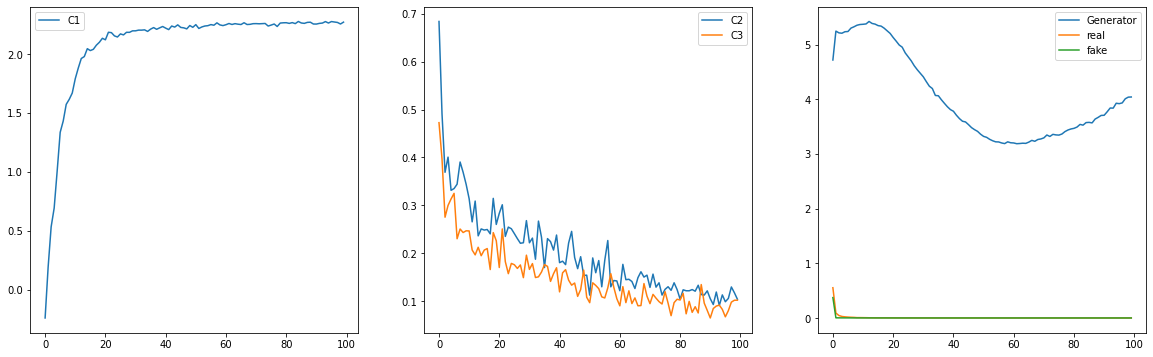

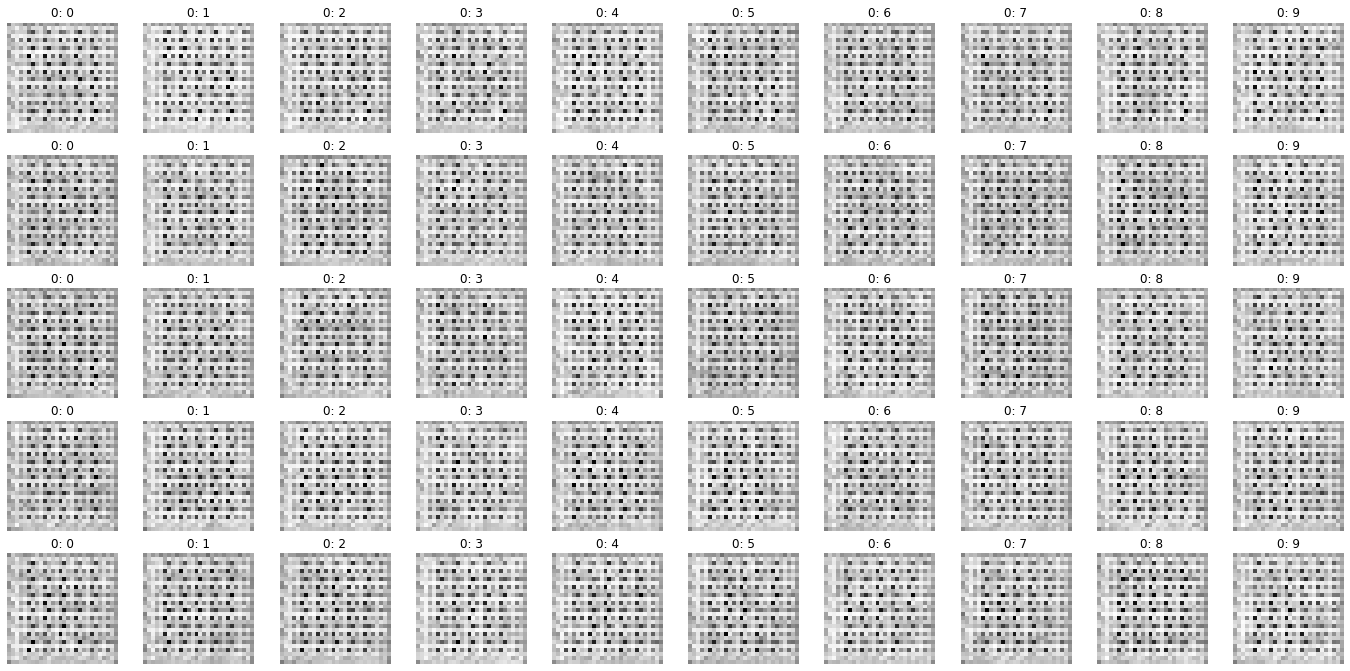

1: 100/100 


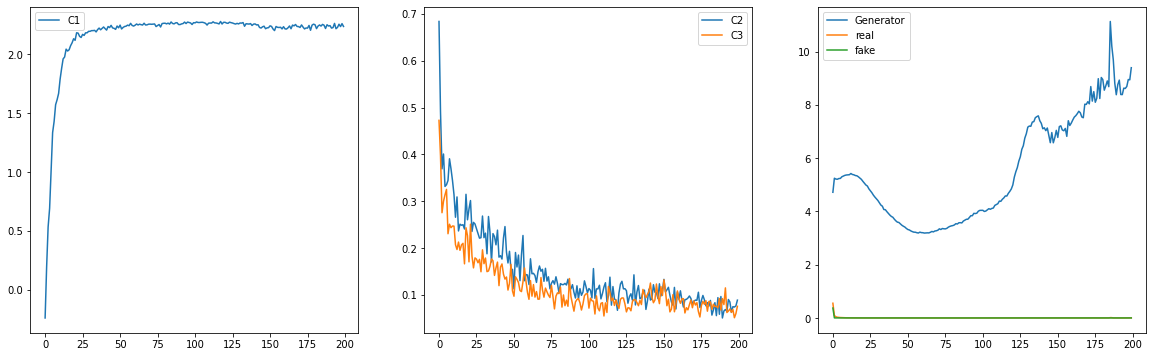

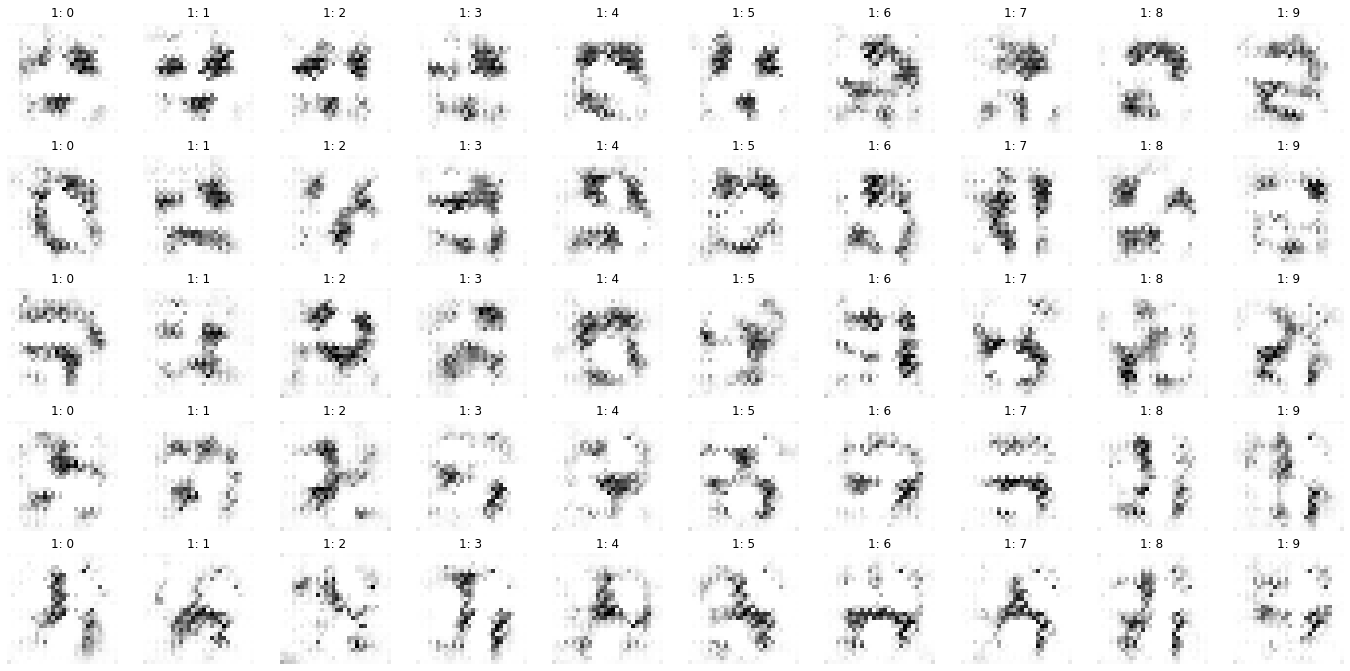

1: 100/100 


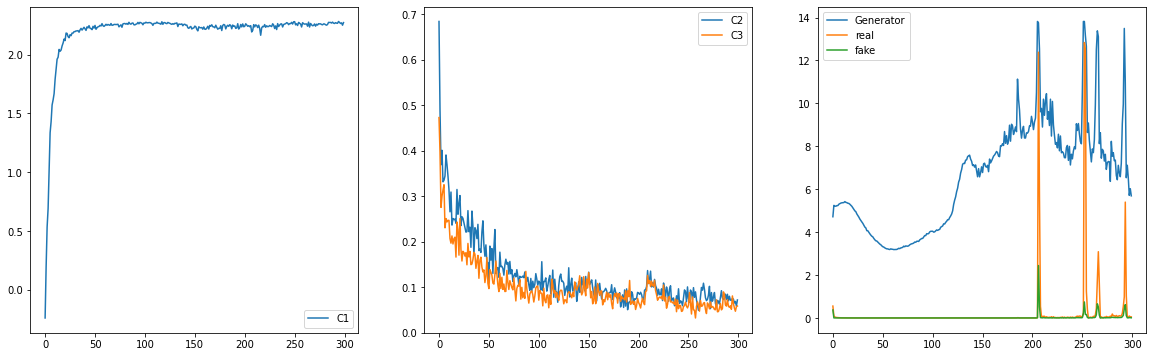

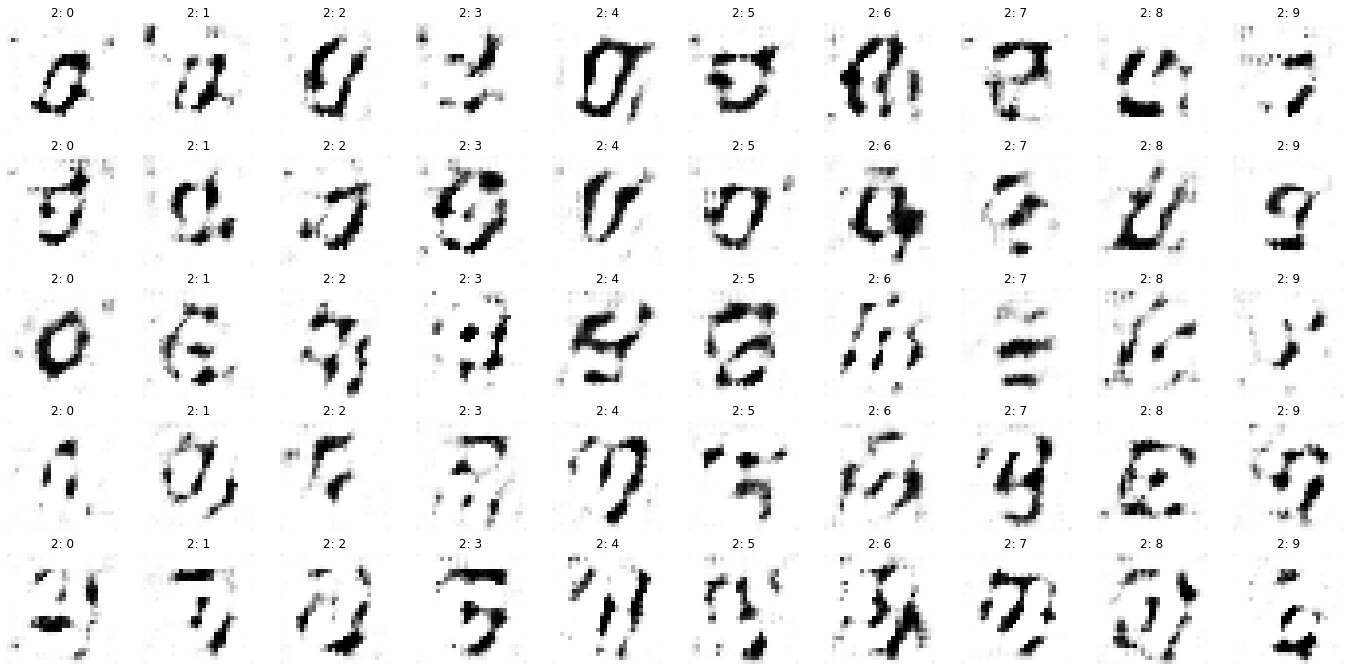

1: 100/100 


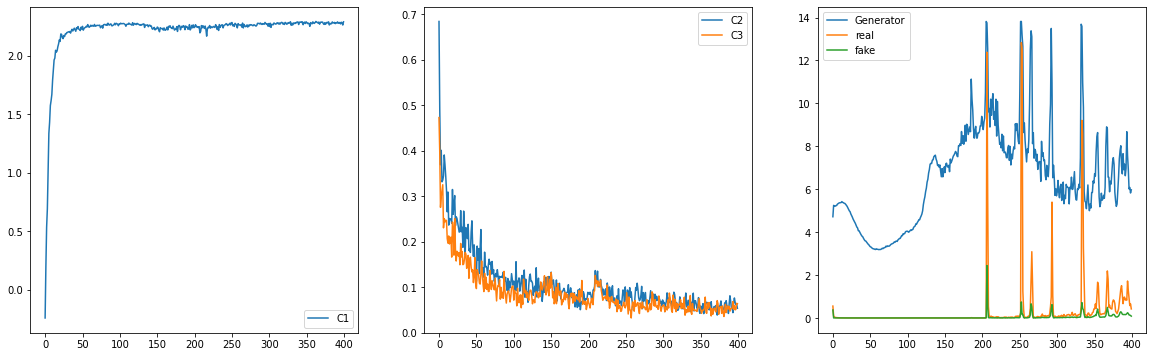

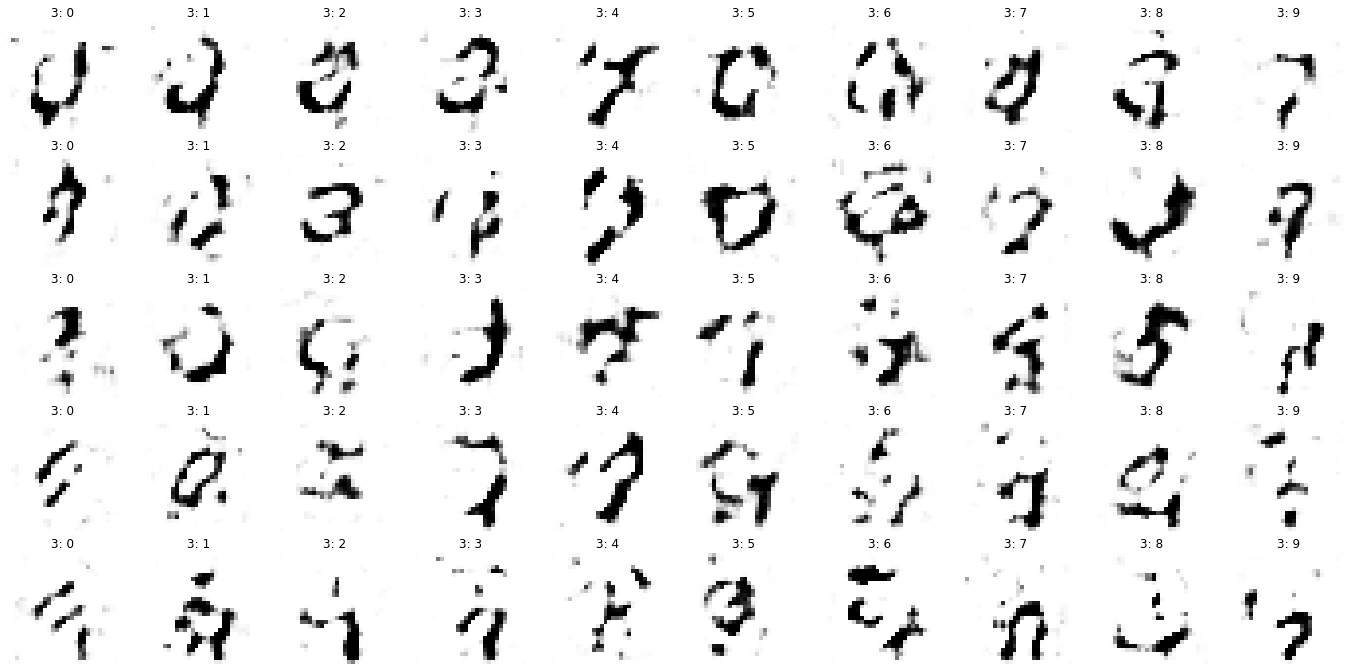

1: 100/100 


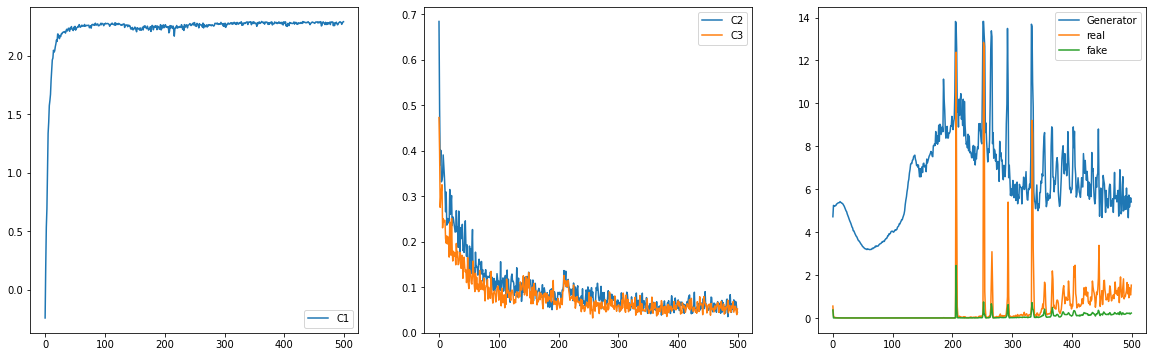

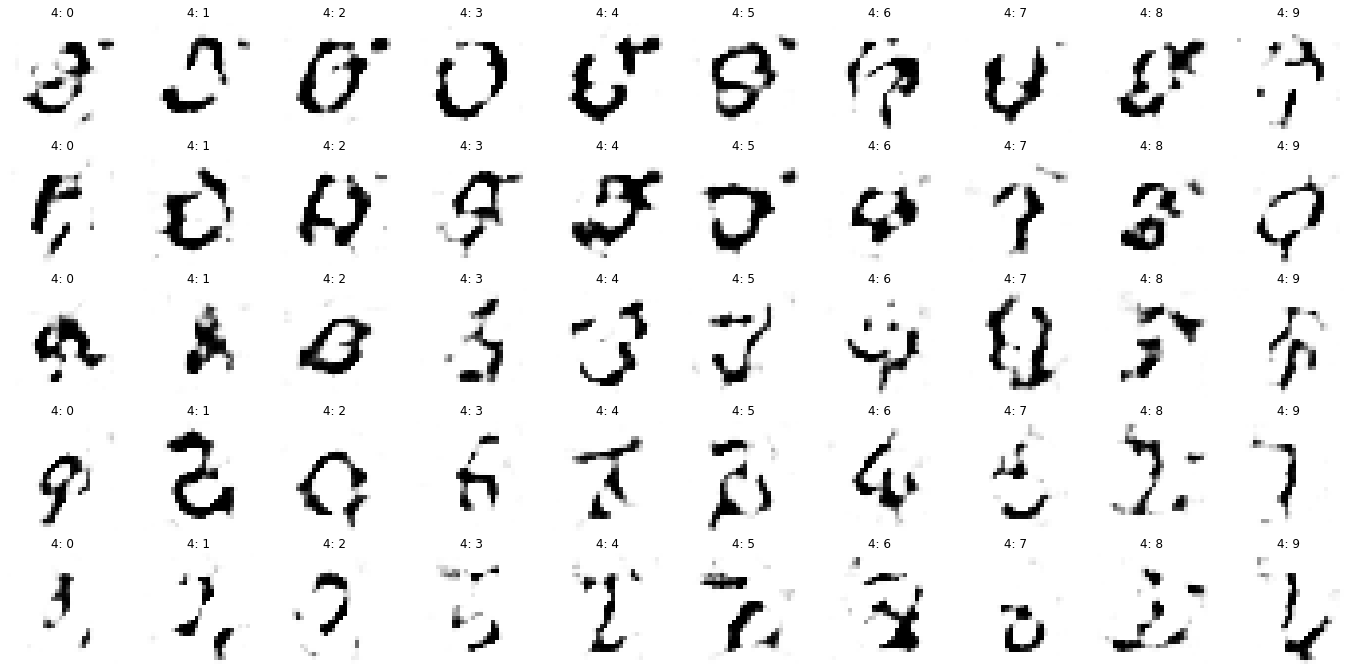

1: 100/100 


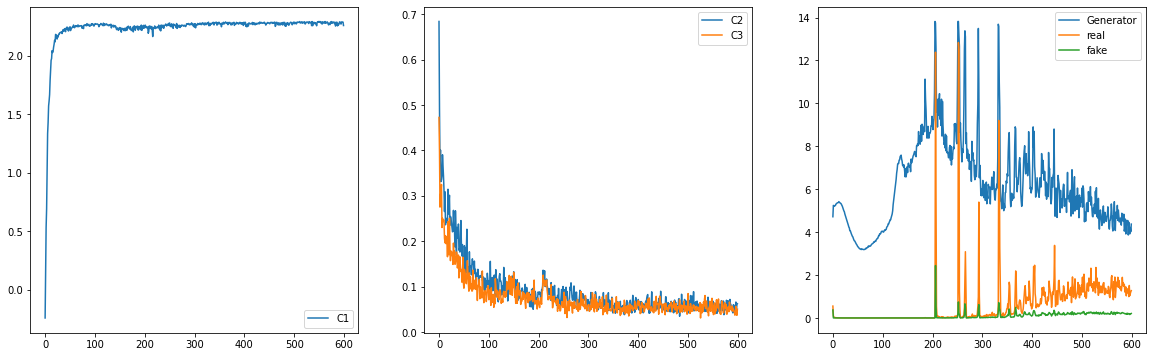

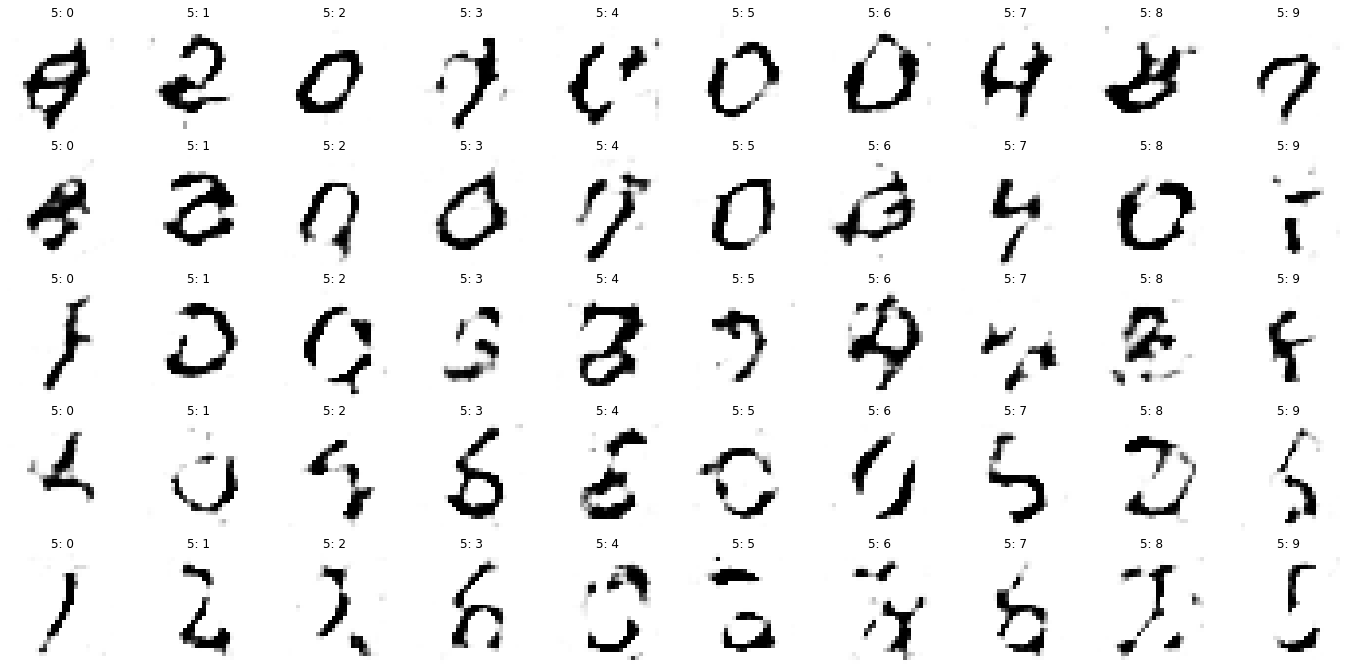

1: 100/100 


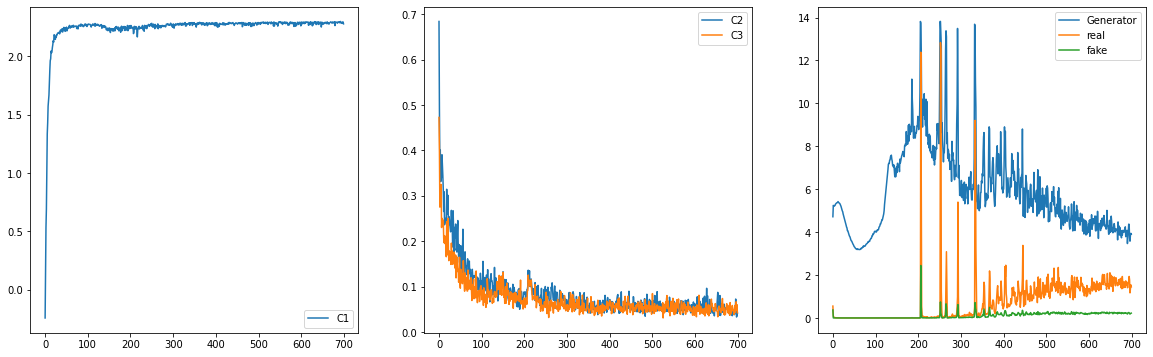

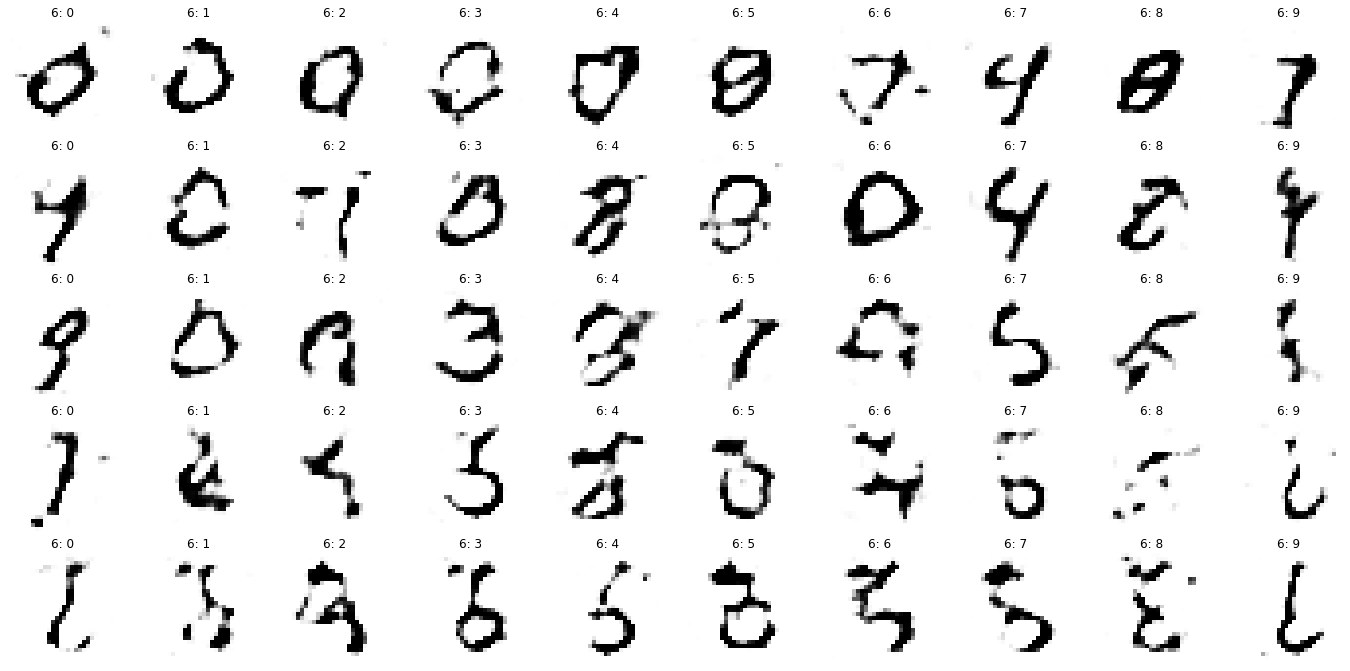

1: 100/100 


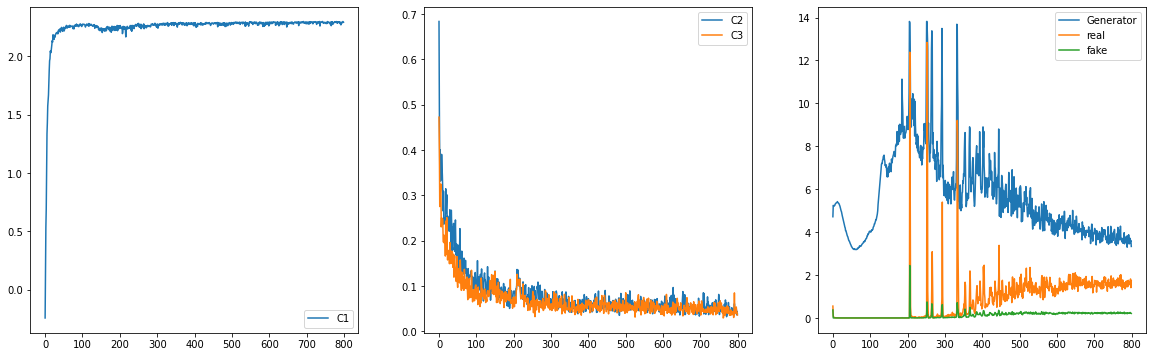

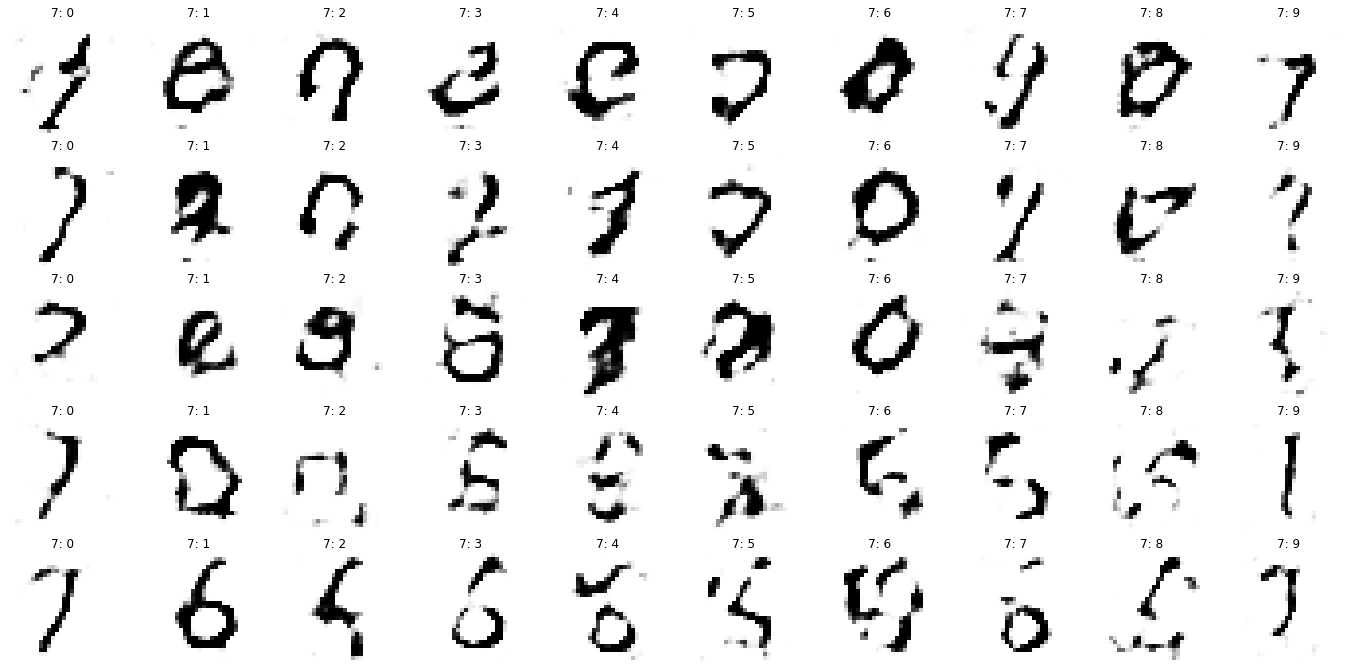

1: 100/100 


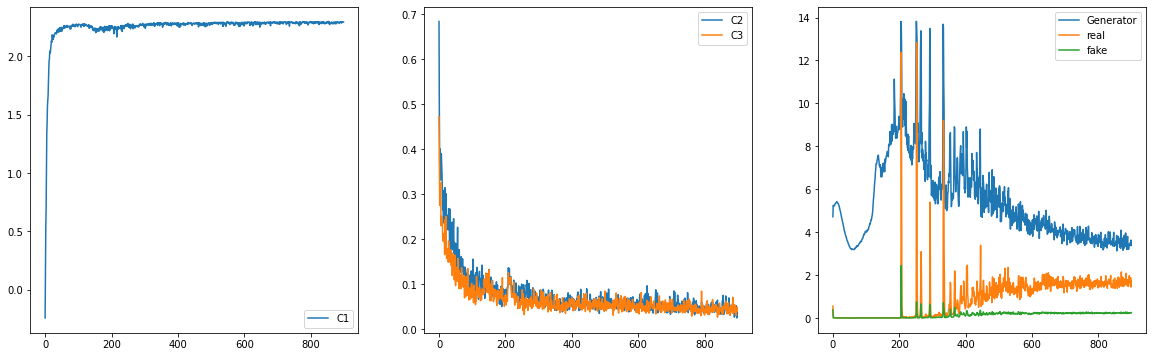

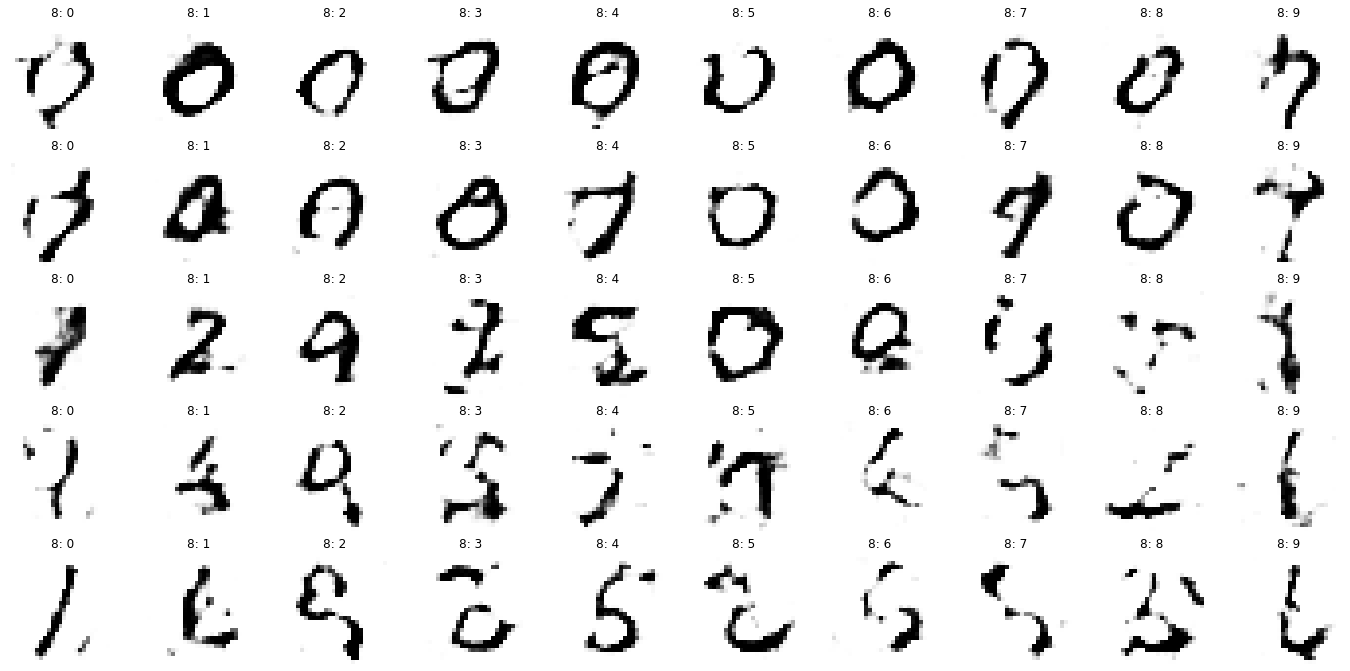

1: 100/100 


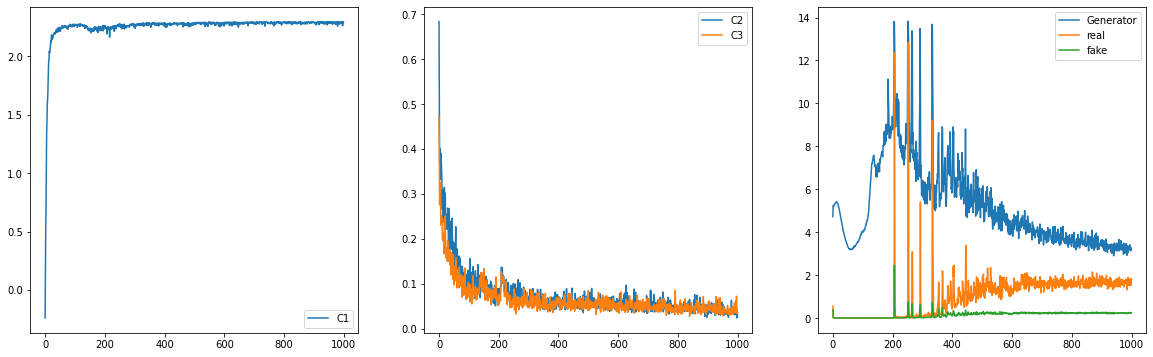

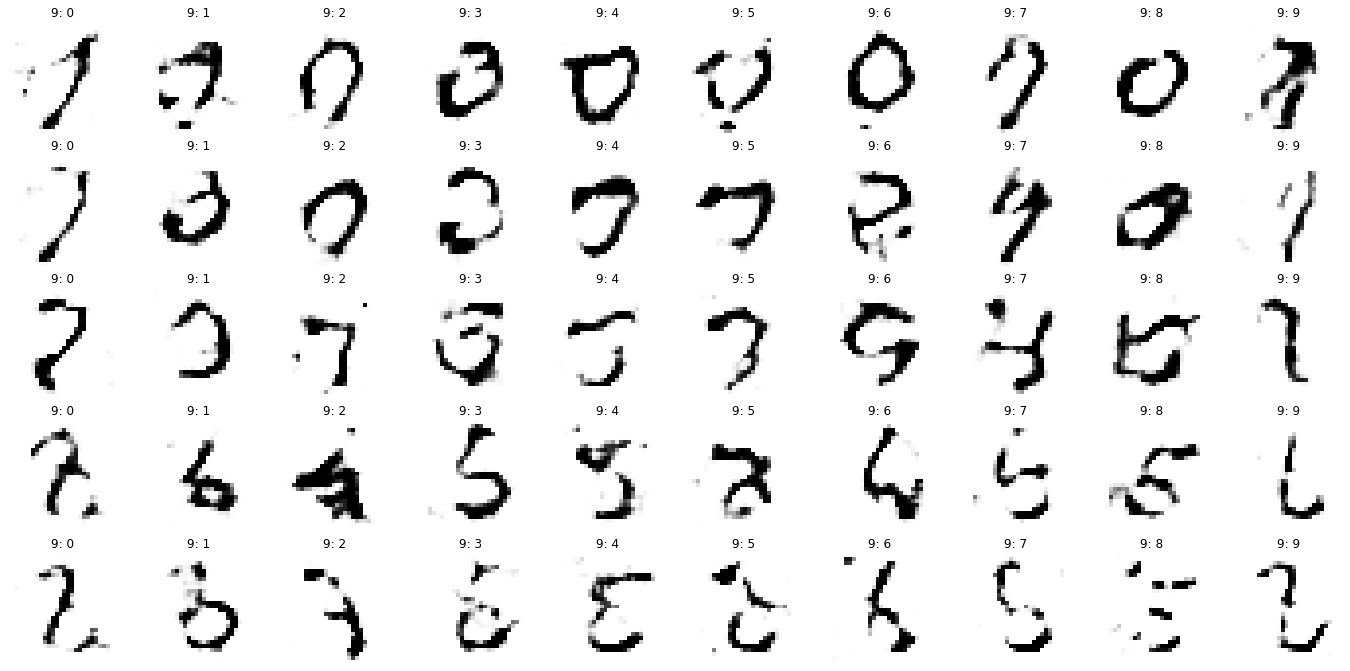

In [22]:
genCustomLoss = True
discCustomLoss = True
qDiscLoss = True

infogan = InfoGAN(
    batch_size = 128,
    latent_dim = 62,
    dlr=1e-4,
    glr=1e-4,
    qcodes = [
        (10, 'categorical'),
        (1 , 'continuous'),
        (1 , 'continuous'),
    ],
)
name = strtime()
mnistTrainPlot(
    infogan,
    epochs = 10,
    steps_per_epoch = 100,
    nrow=5,
    name=name,
)

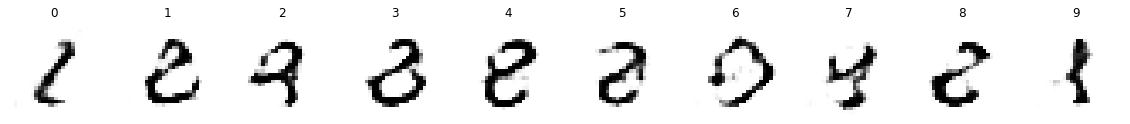

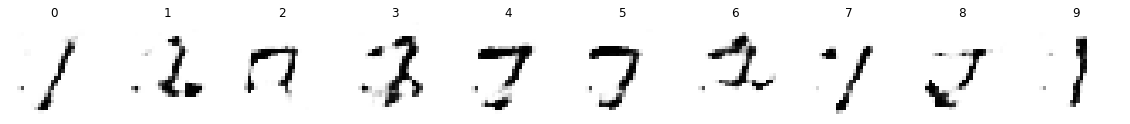

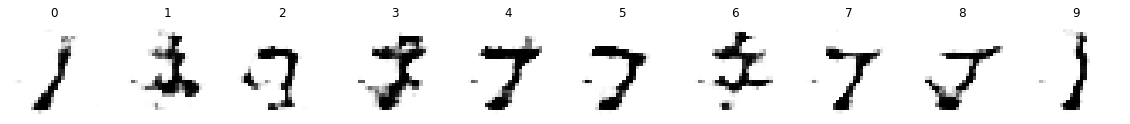

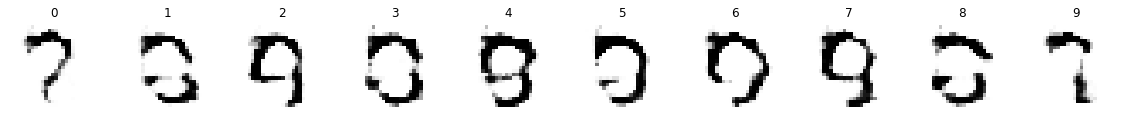

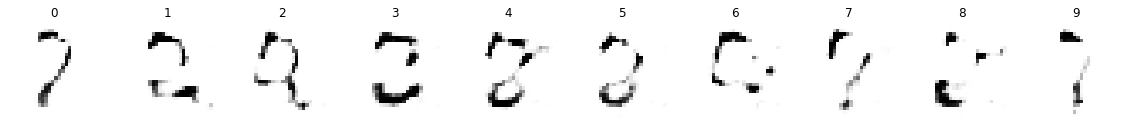

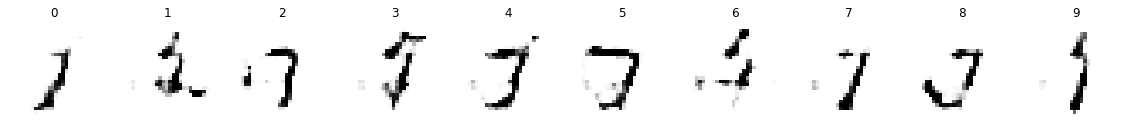

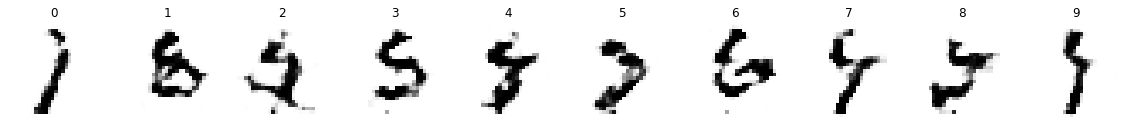

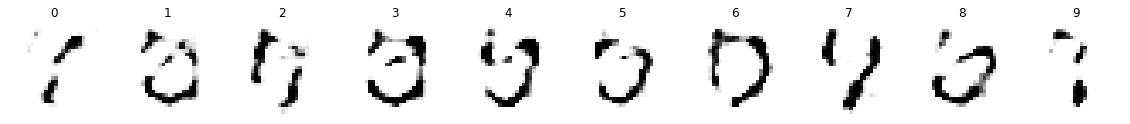

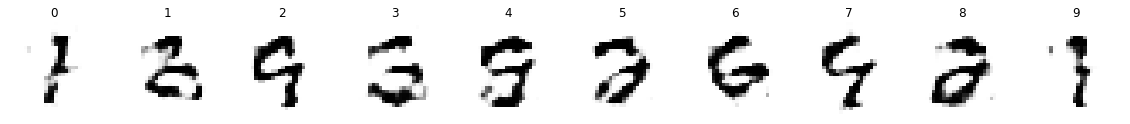

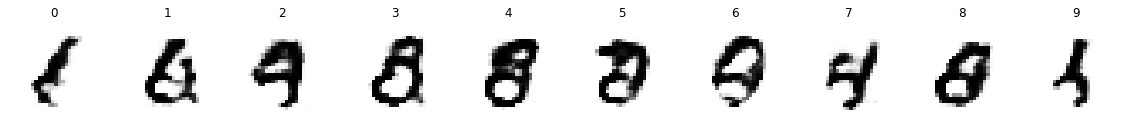

In [23]:
for i in range(10):
    plotc1(infogan.gen, seed = i * i + i * 3 - i // 2)

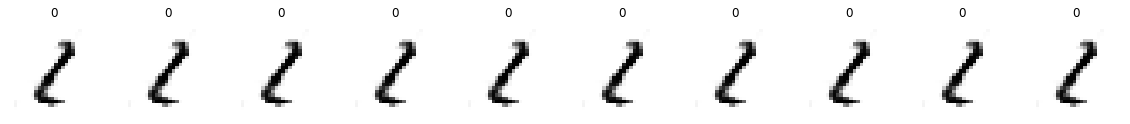

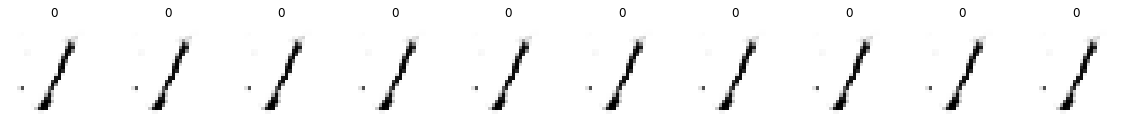

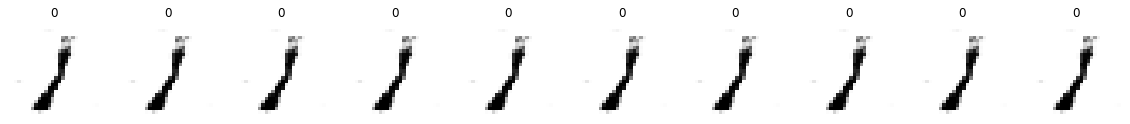

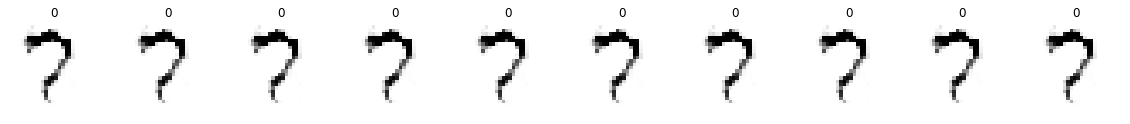

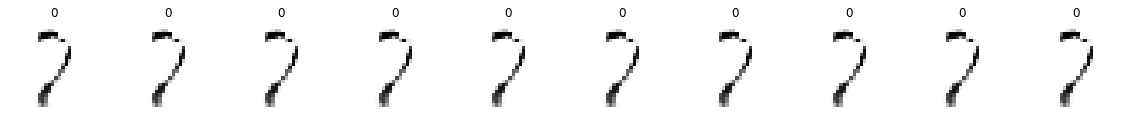

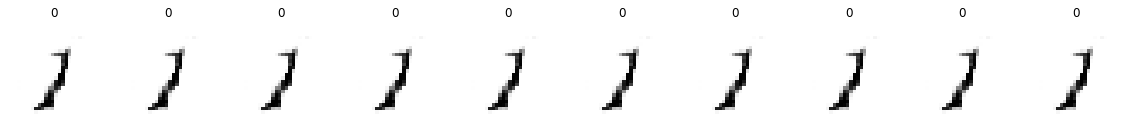

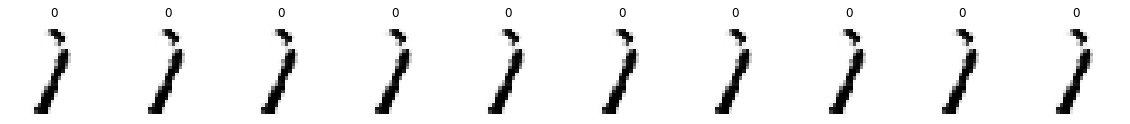

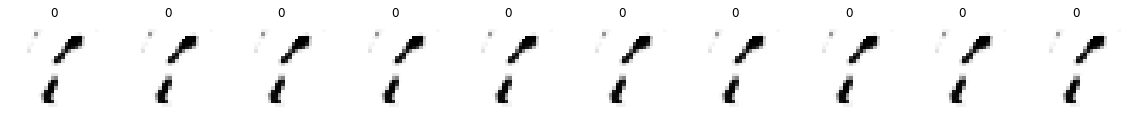

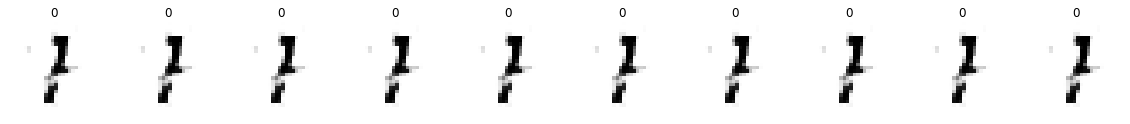

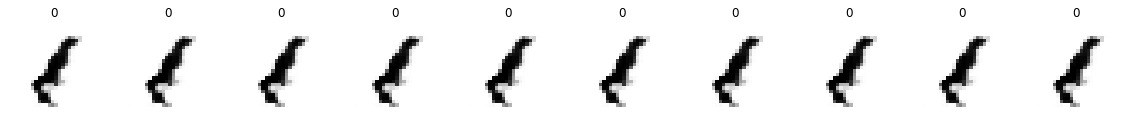

In [24]:
for i in range(10):
    plotc23(infogan.gen, seed = i * i + i * 3 - i // 2)

1: 100/100 


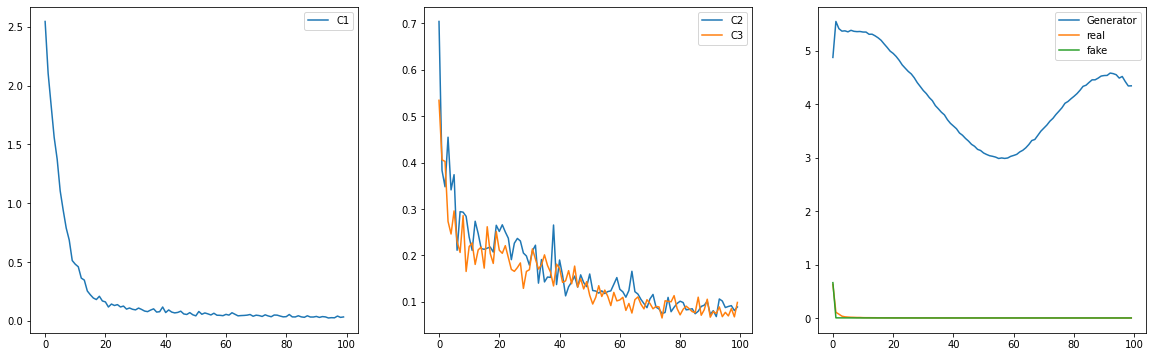

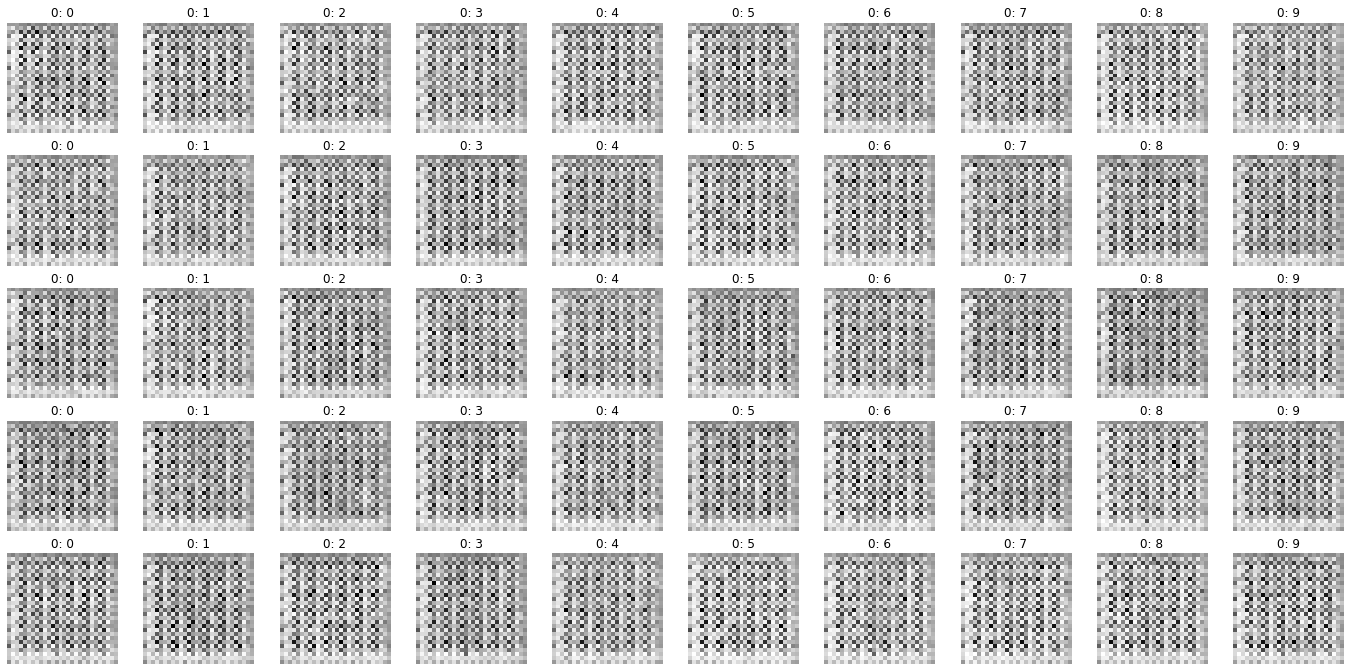

1: 100/100 


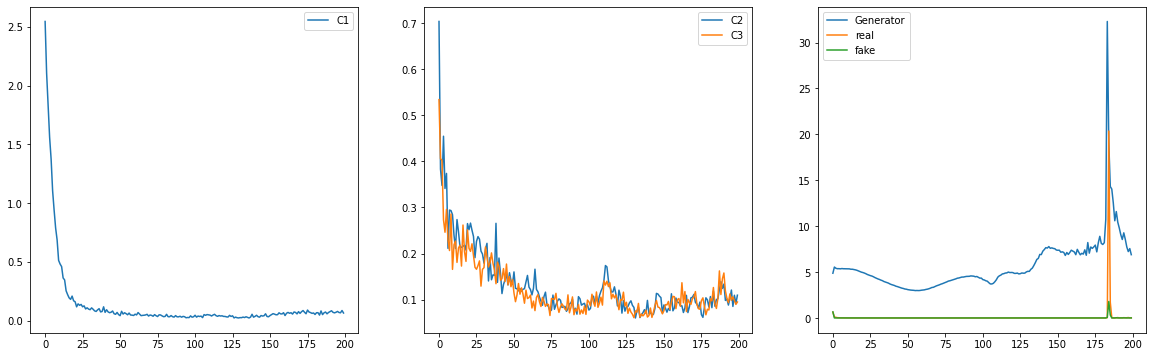

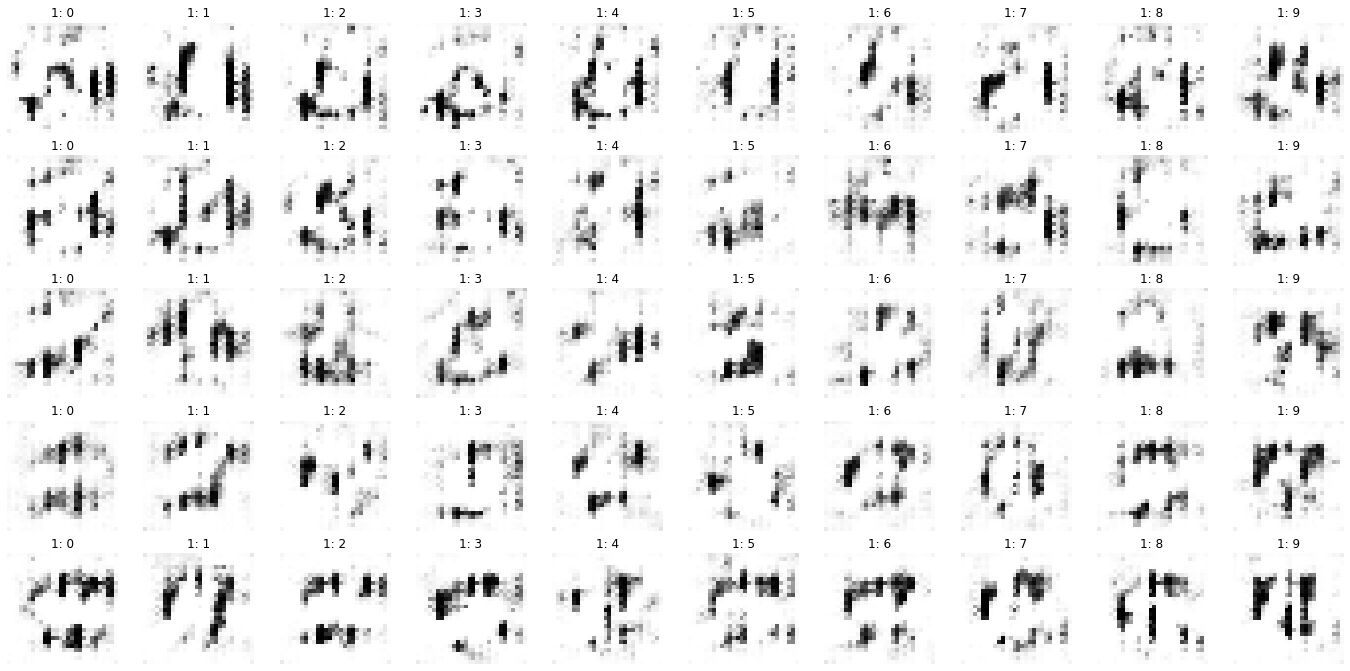

1: 100/100 


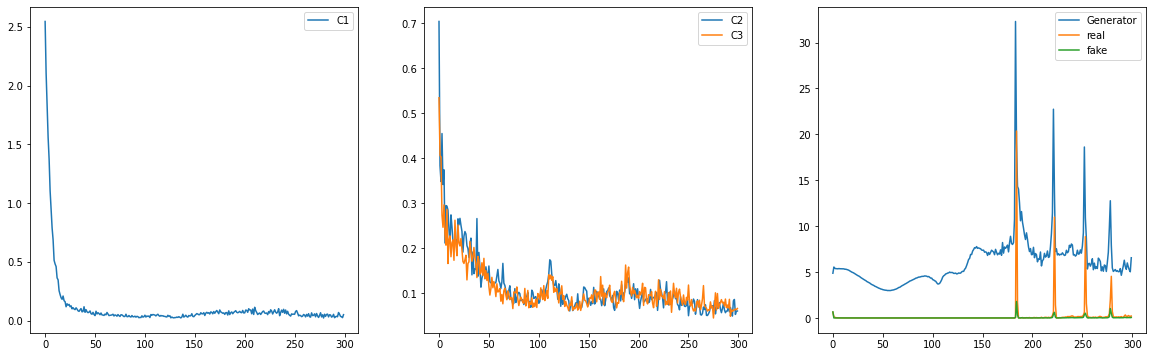

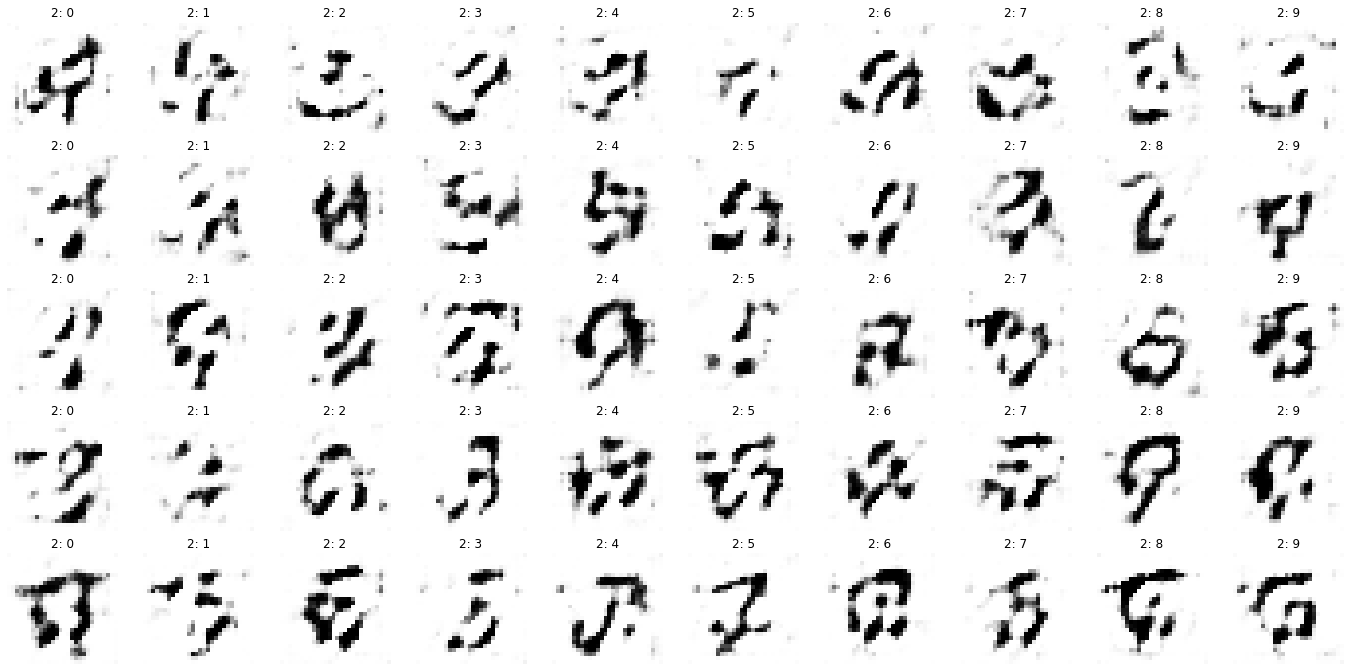

1: 100/100 


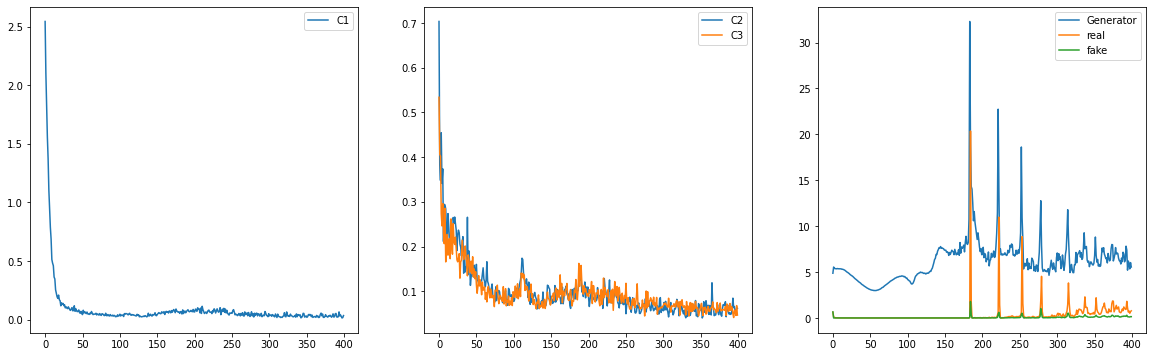

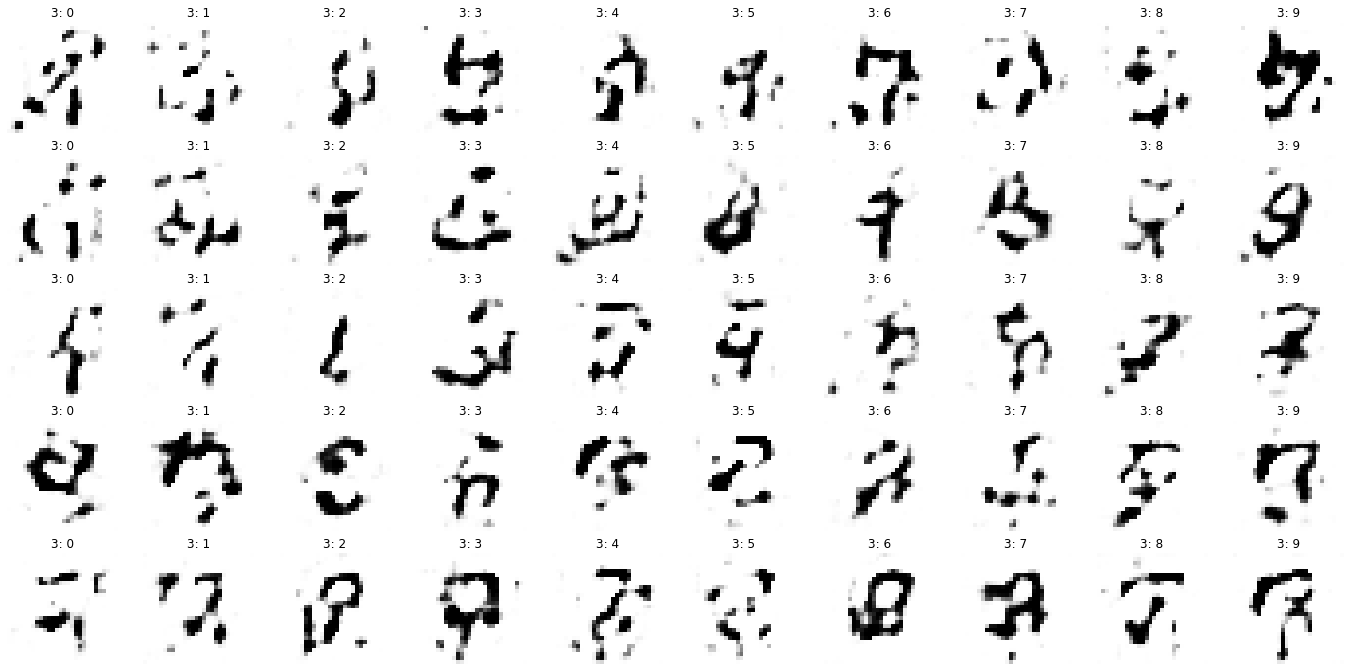

1: 100/100 


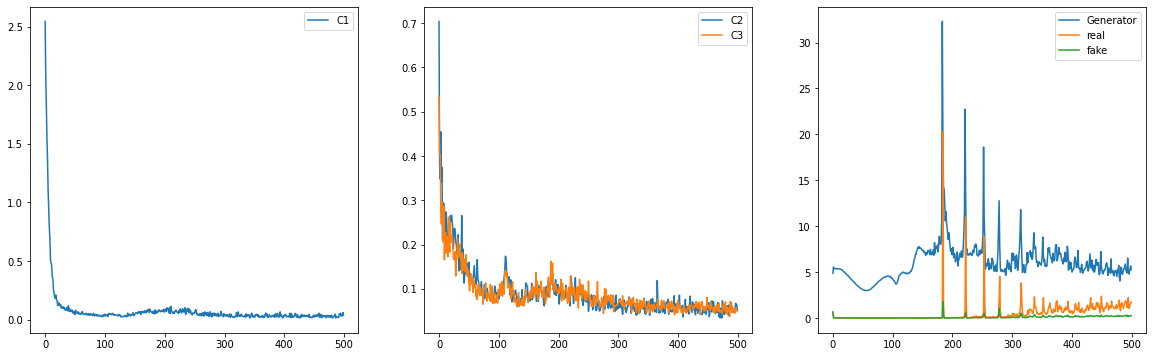

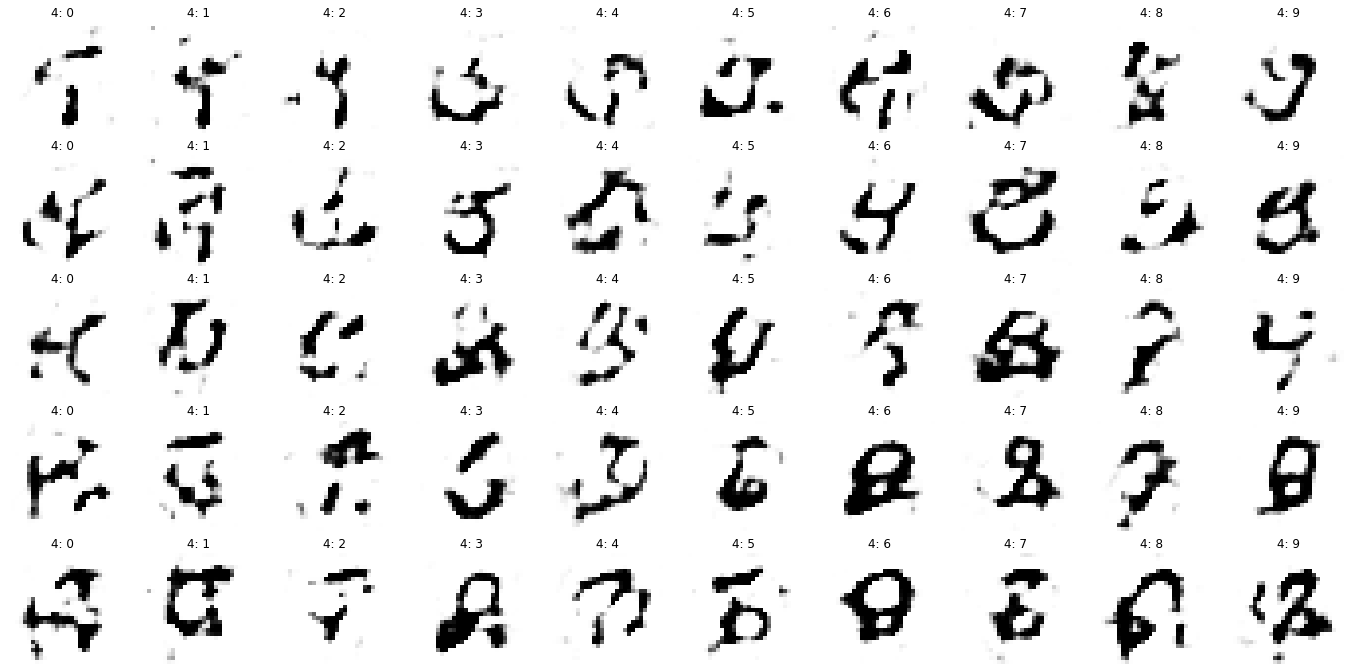

1: 100/100 


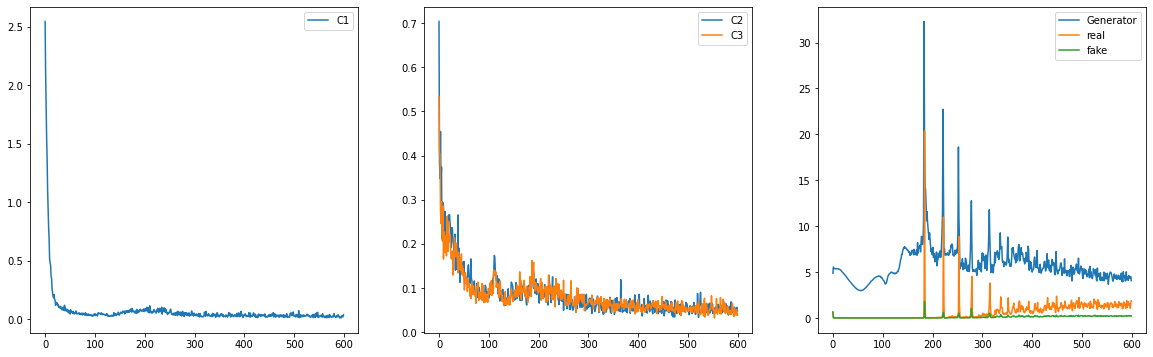

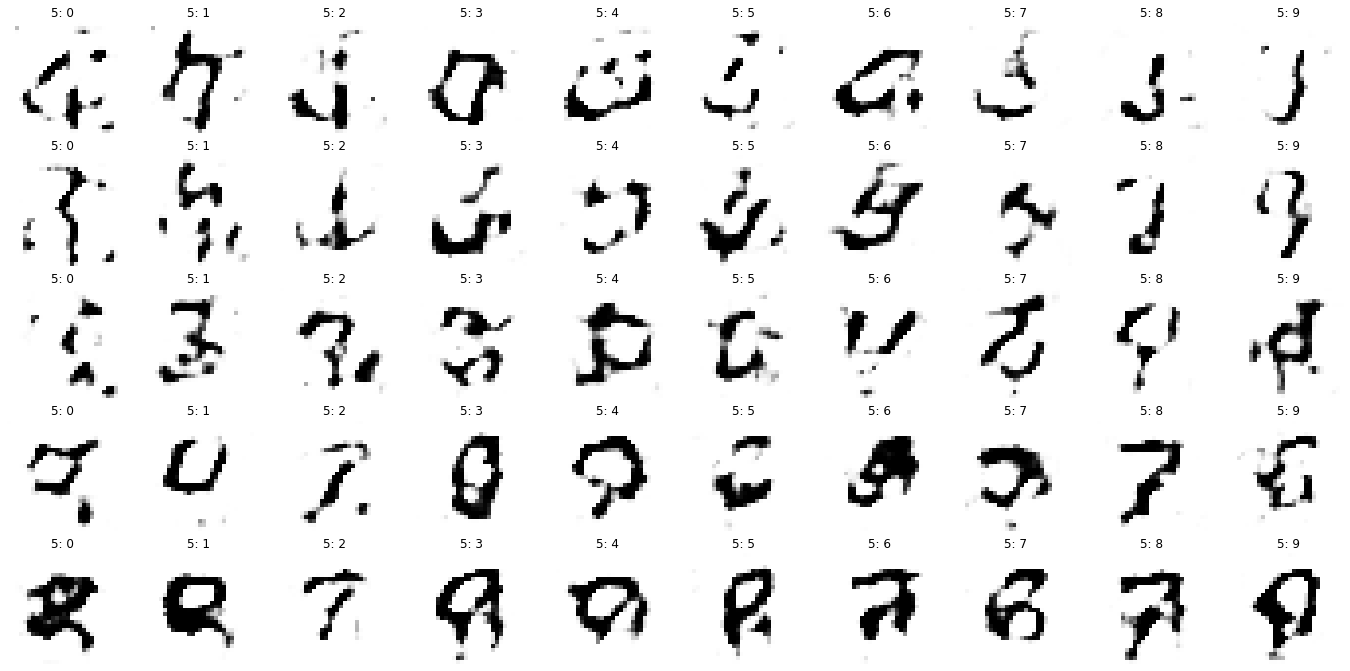

1: 100/100 


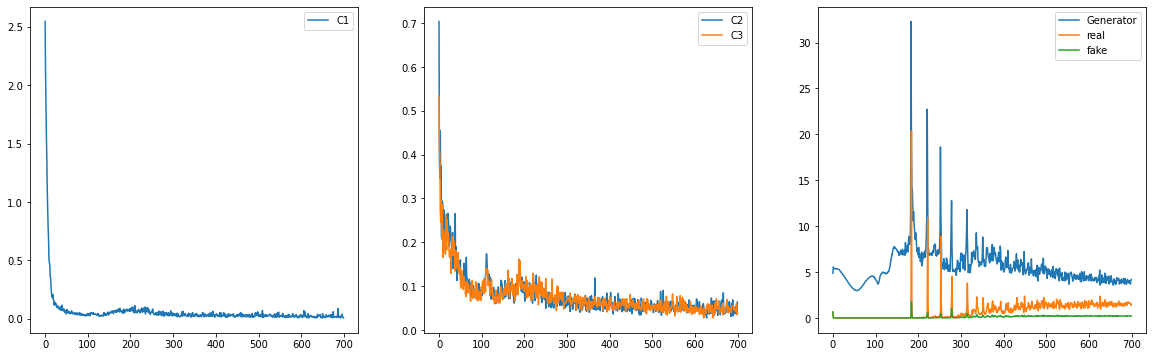

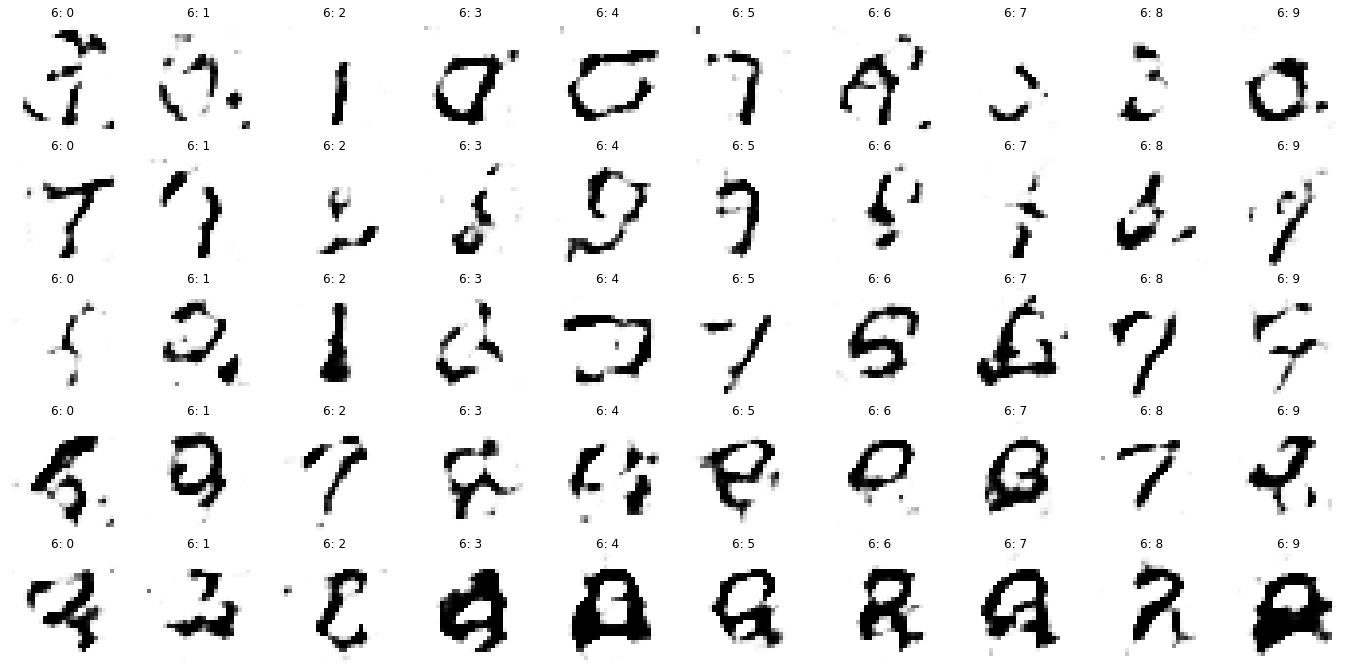

1: 100/100 


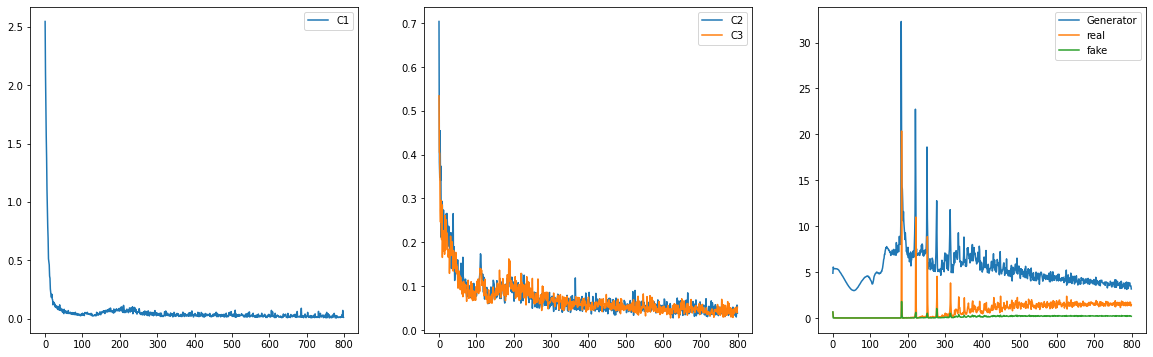

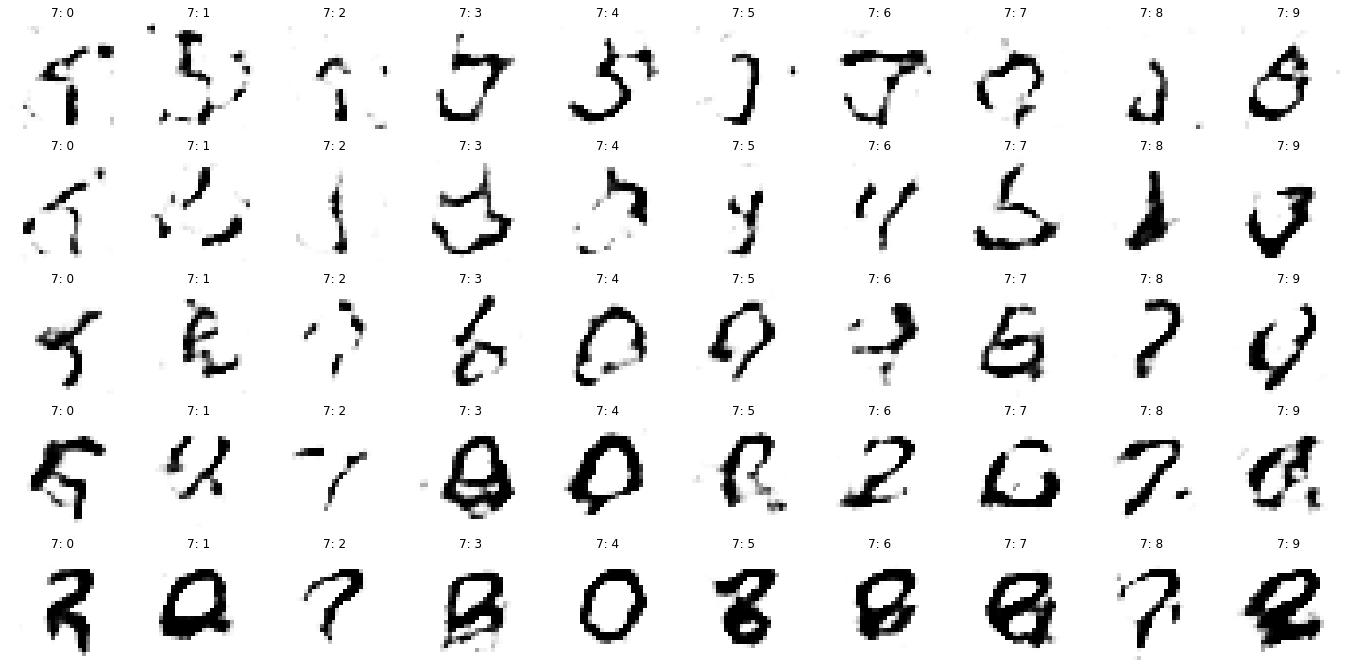

1: 100/100 


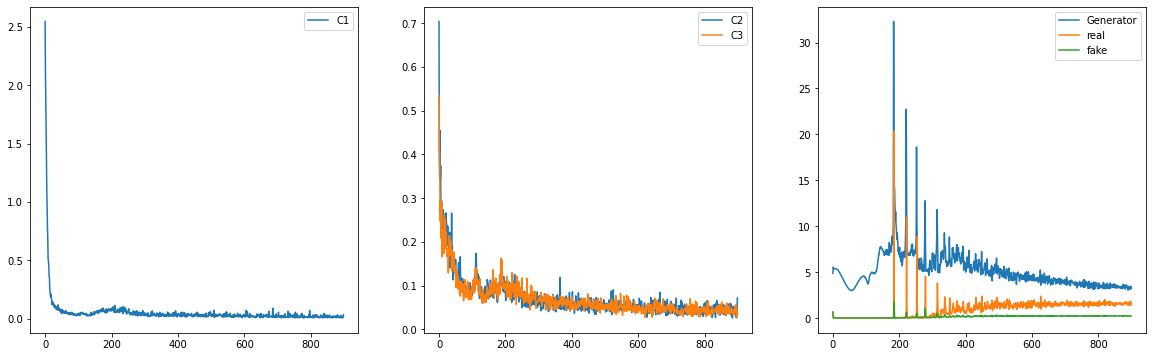

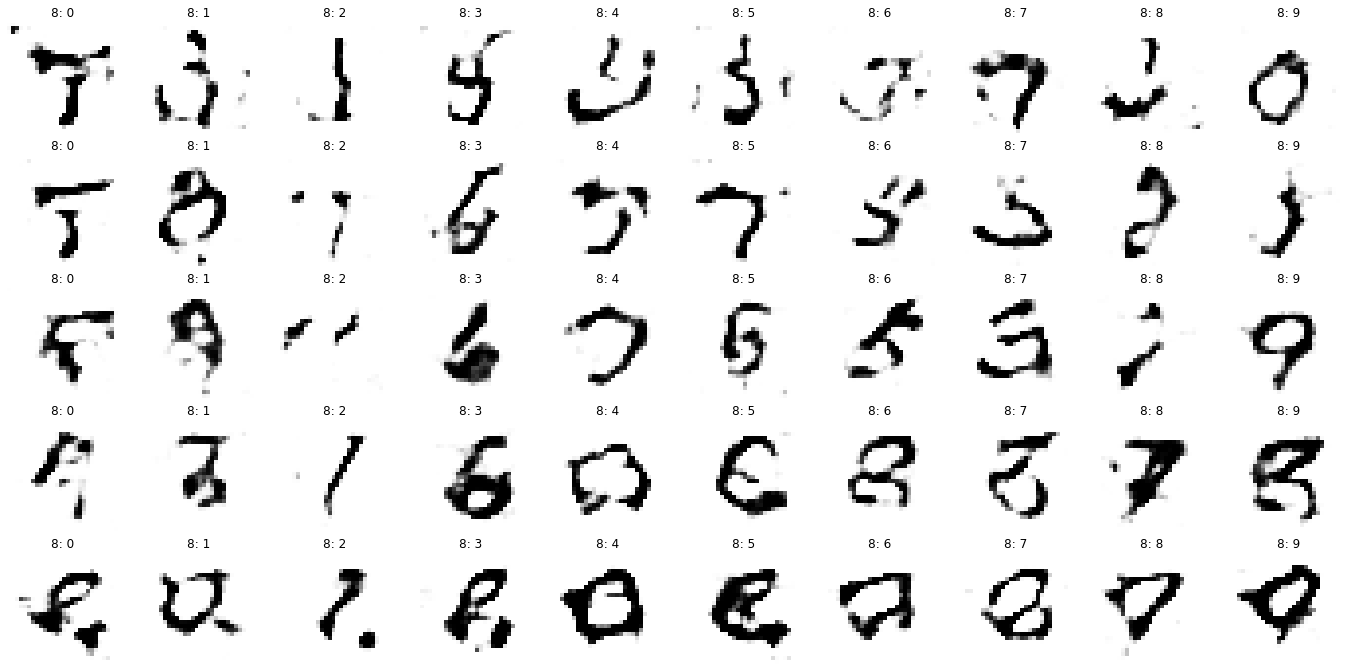

1: 100/100 


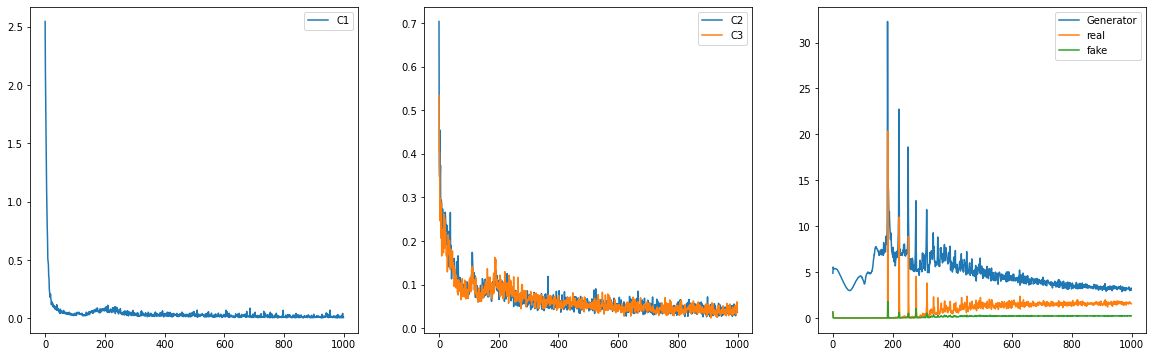

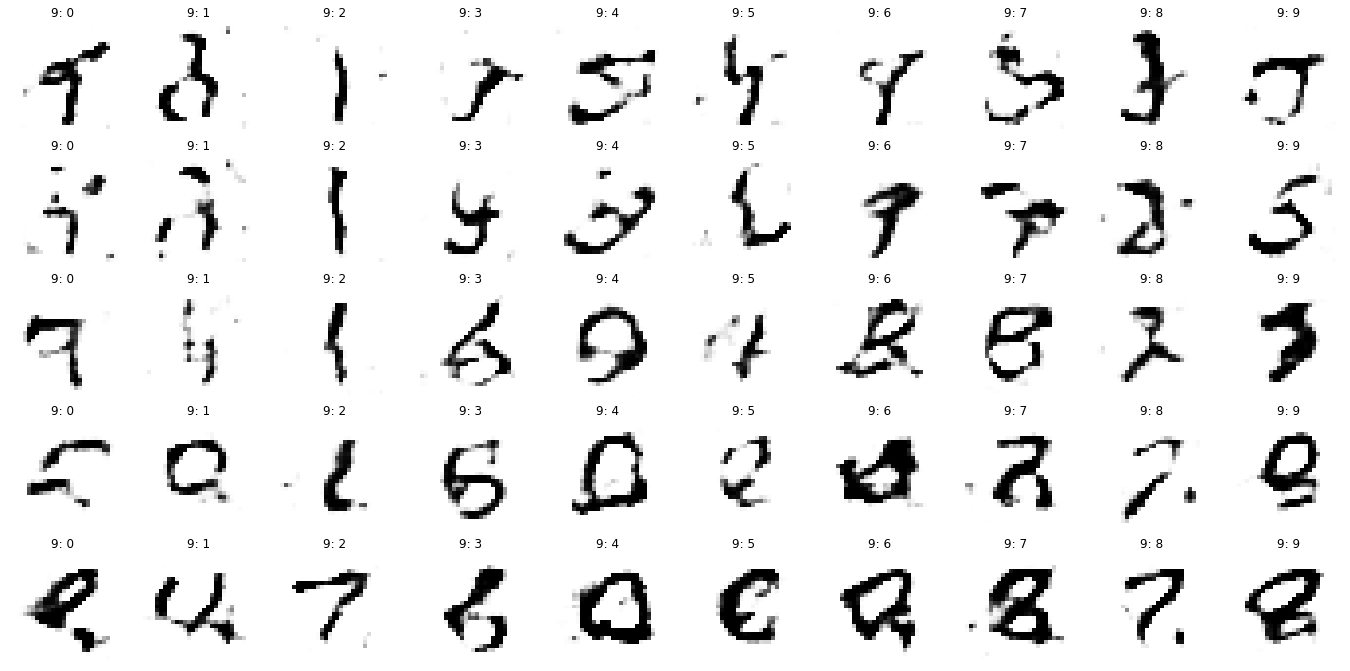

In [25]:
genCustomLoss = False
discCustomLoss = False
qDiscLoss = False

infogan = InfoGAN(
    batch_size = 128,
    latent_dim = 62,
    dlr=1e-4,
    glr=1e-4,
    qcodes = [
        (10, 'categorical'),
        (1 , 'continuous'),
        (1 , 'continuous'),
    ],
)
name = strtime()
mnistTrainPlot(
    infogan,
    epochs = 10,
    steps_per_epoch = 100,
    nrow=5,
    name=name,
)

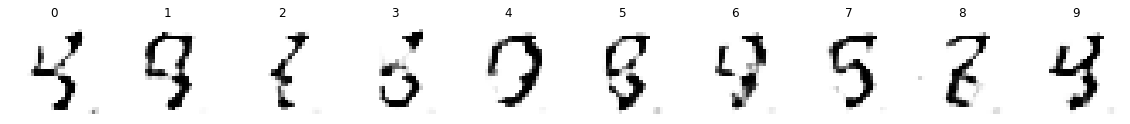

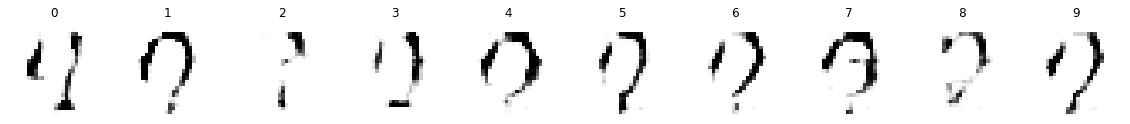

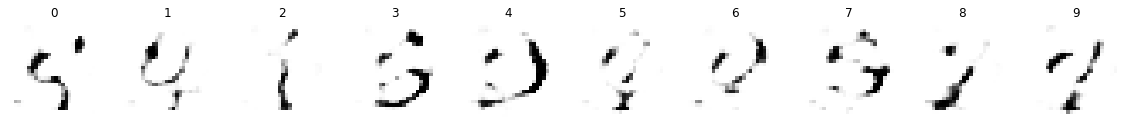

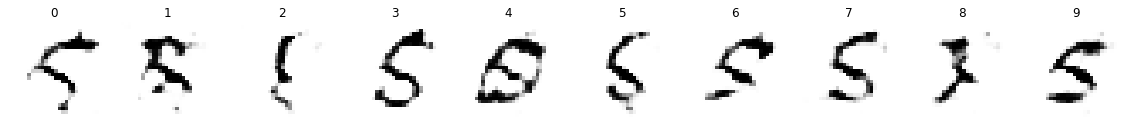

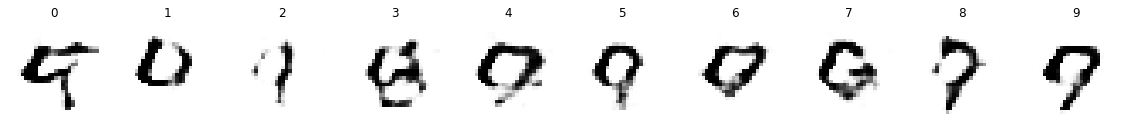

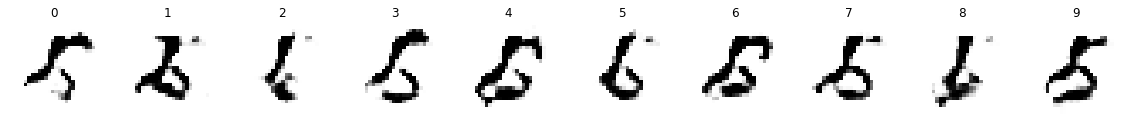

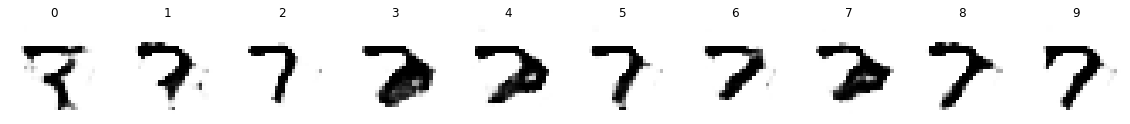

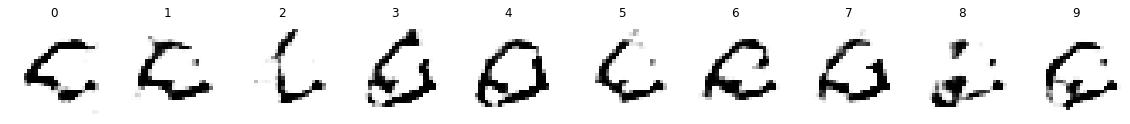

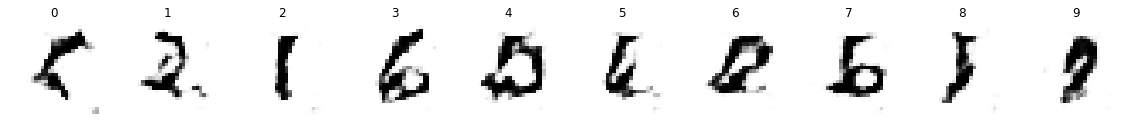

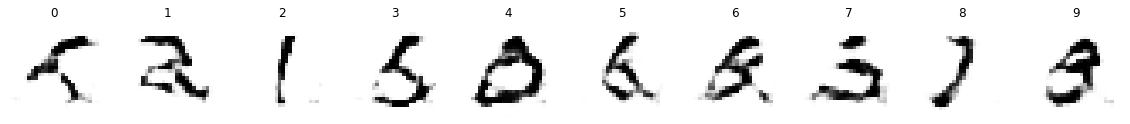

In [26]:
for i in range(10):
    plotc1(infogan.gen, seed = i * i + i * 3 - i // 2)

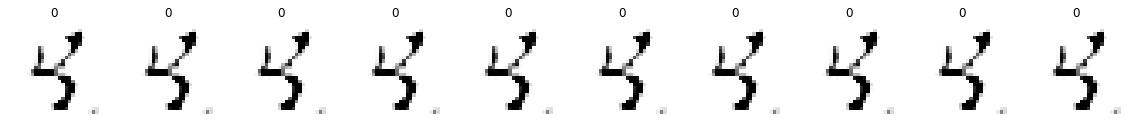

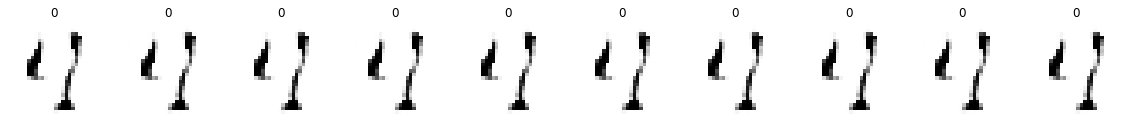

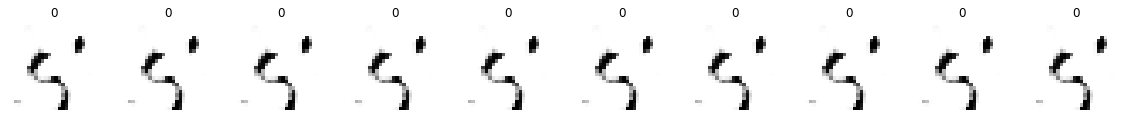

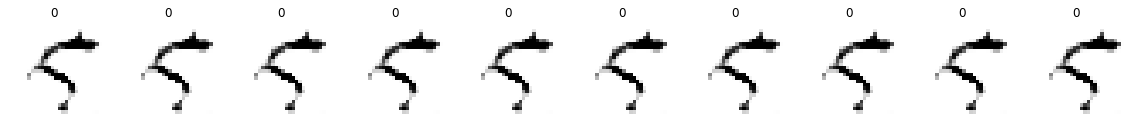

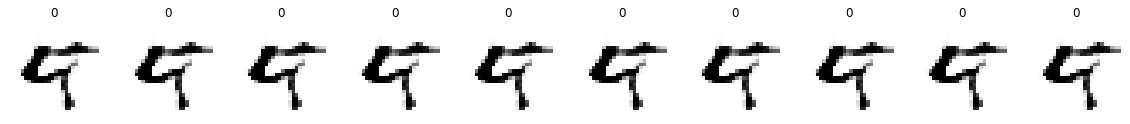

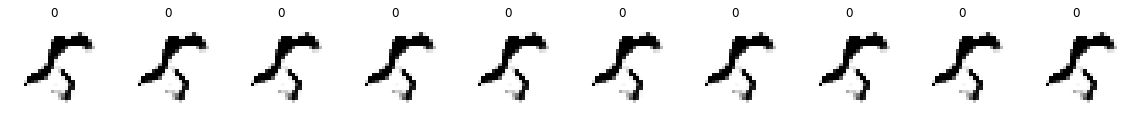

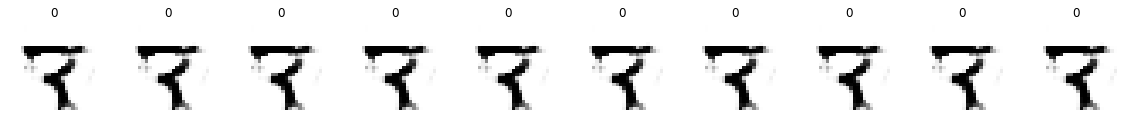

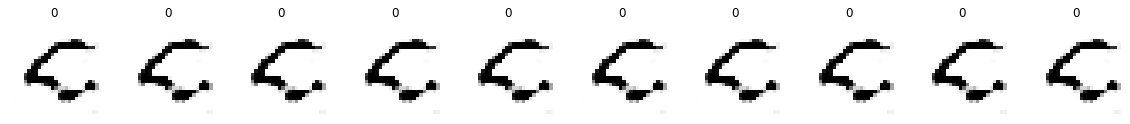

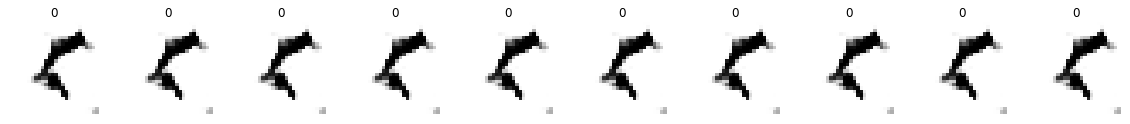

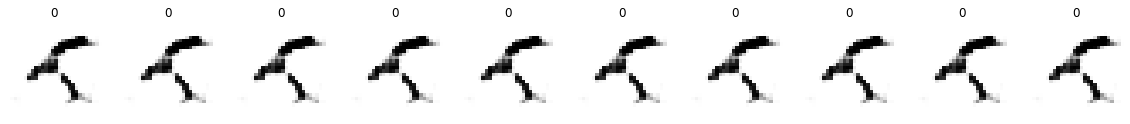

In [27]:
for i in range(10):
    plotc23(infogan.gen, seed = i * i + i * 3 - i // 2)